## import 

In [ ]:
!python -m pip install polars pyarrow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import scipy.stats as stats
from tqdm import tqdm

import polars as pl

## Lower bound entropy of the whole dataset

In [2]:
data_dir = Path("../data/variations_wc/6switches_3values_min1_max20_10K")
lower_bound_complexity = []

# フォルダ名からgrammar_namesを取得
grammar_names = [d.name for d in data_dir.iterdir() if d.is_dir()]
print(len(grammar_names))
valid_grammar = 0
for grammar_name in grammar_names:
    if not (
        data_dir / grammar_name / "true_prob" / "lower_bound_entropy.value"
    ).exists():
        if not (
            data_dir / grammar_name / "true_prob" / "probability_split_1_of_1.csv.gz"
        ).exists():
            print(f"{grammar_name} is not valid")

200


In [4]:
data_dir = Path("../data/variations_wc/6switches_3values_min1_max20_10K")
lower_bound_complexity = []

# フォルダ名からgrammar_namesを取得
grammar_names = [d.name for d in data_dir.iterdir() if d.is_dir()]

for grammar_name in grammar_names:
    true_prob_dir = data_dir / grammar_name / "true_prob"

    try:
        # entropyとperplexityの値を読み込む
        with open(true_prob_dir / "lower_bound_entropy.value") as f:
            entropy = float(f.read().strip())

        with open(true_prob_dir / "lower_bound_perplexity.value") as f:
            perplexity = float(f.read().strip())

        lower_bound_complexity.append(
            {
                "grammar_name": grammar_name,
                "lower_bound_entropy": entropy,
                "lower_bound_perplexity": perplexity,
            }
        )
    except:
        print(f"Can't find {true_prob_dir}")

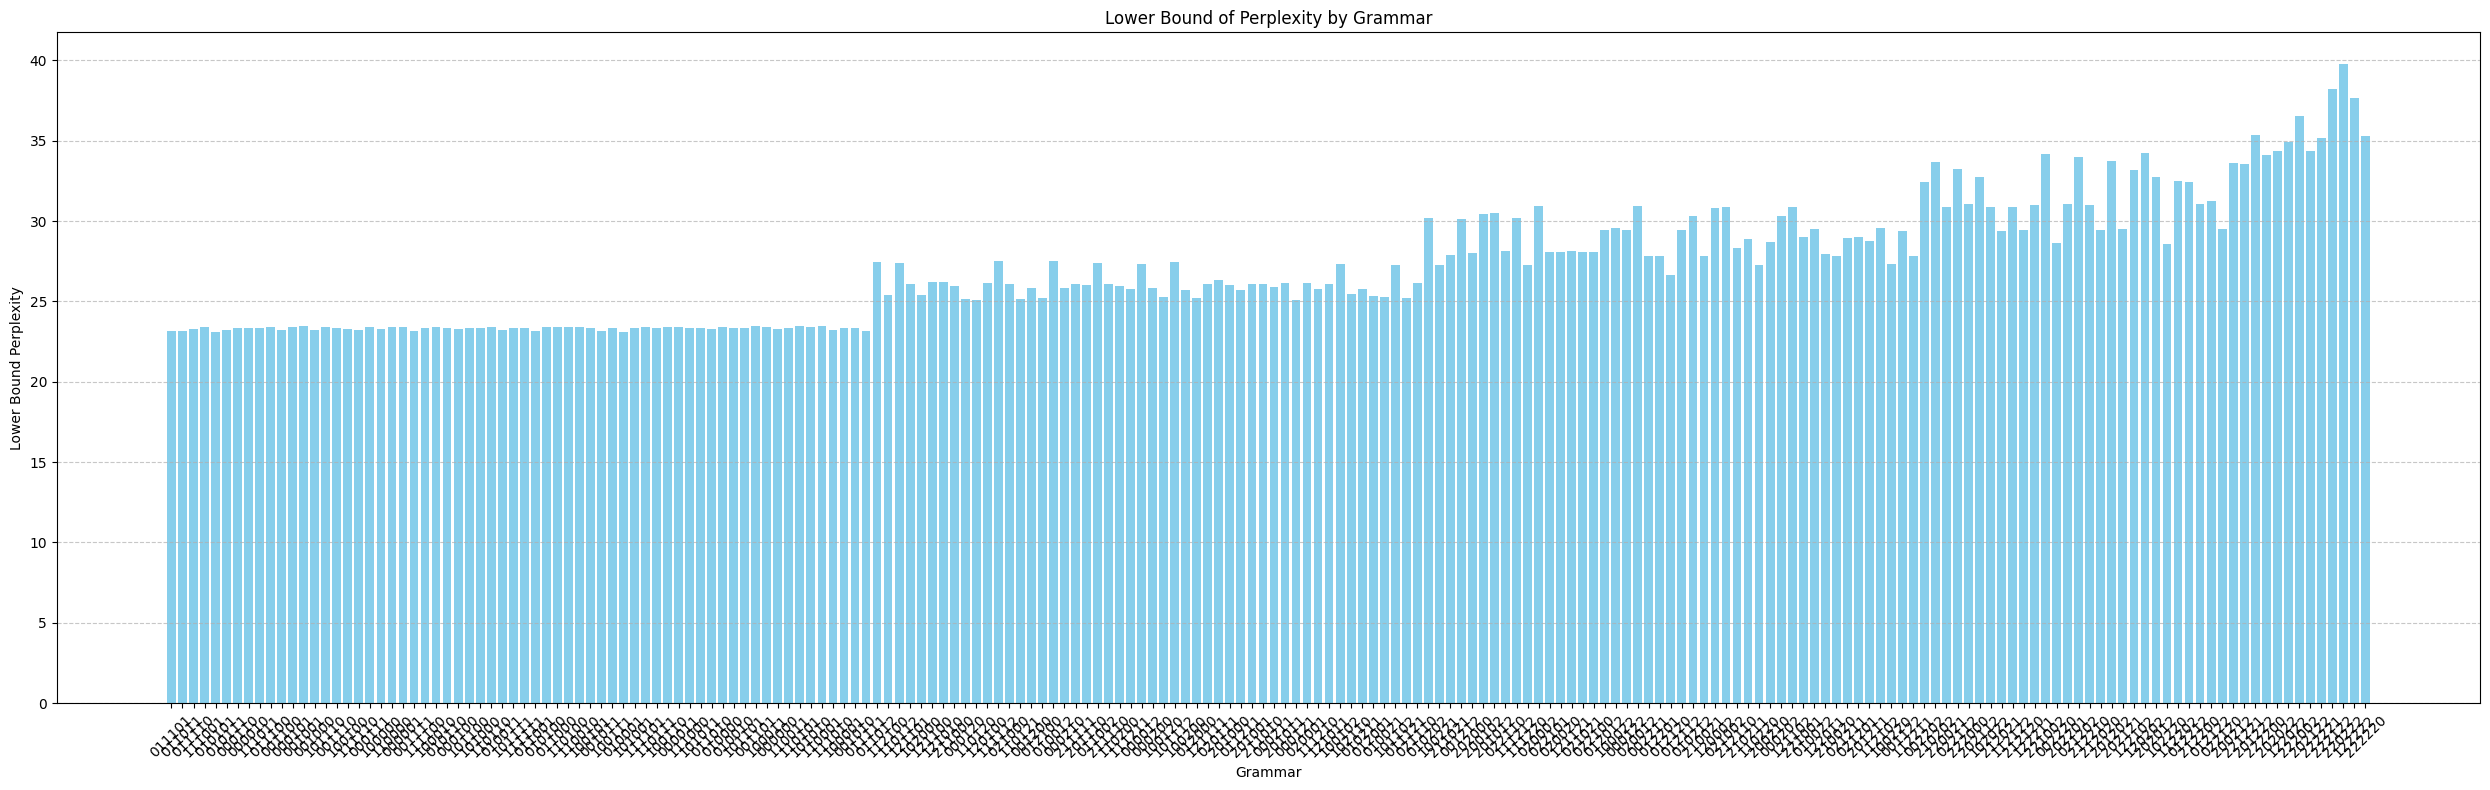

In [5]:
# 理論下限のプロット
fig, ax = plt.subplots(figsize=(25, 8))

# DataFrameに変換して扱いやすくする
lower_bound_df = pd.DataFrame(lower_bound_complexity)

# '2'の数が少ない順にソート
lower_bound_df["num_twos"] = lower_bound_df["grammar_name"].apply(
    lambda x: x.count("2")
)
lower_bound_df = lower_bound_df.sort_values(by="num_twos").drop(columns="num_twos")


# プロット
ax.bar(
    lower_bound_df["grammar_name"],
    lower_bound_df["lower_bound_perplexity"],
    color="skyblue",
)

# 見やすさの調整
ax.set_xticks(range(len(list(lower_bound_df["grammar_name"].values))))
ax.set_xticklabels(
    list(lower_bound_df["grammar_name"].values), rotation=45, fontsize=10
)
ax.set_xlabel("Grammar")
ax.set_ylabel("Lower Bound Perplexity")
ax.set_title("Lower Bound of Perplexity by Grammar")


# グリッドと余白の調整
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

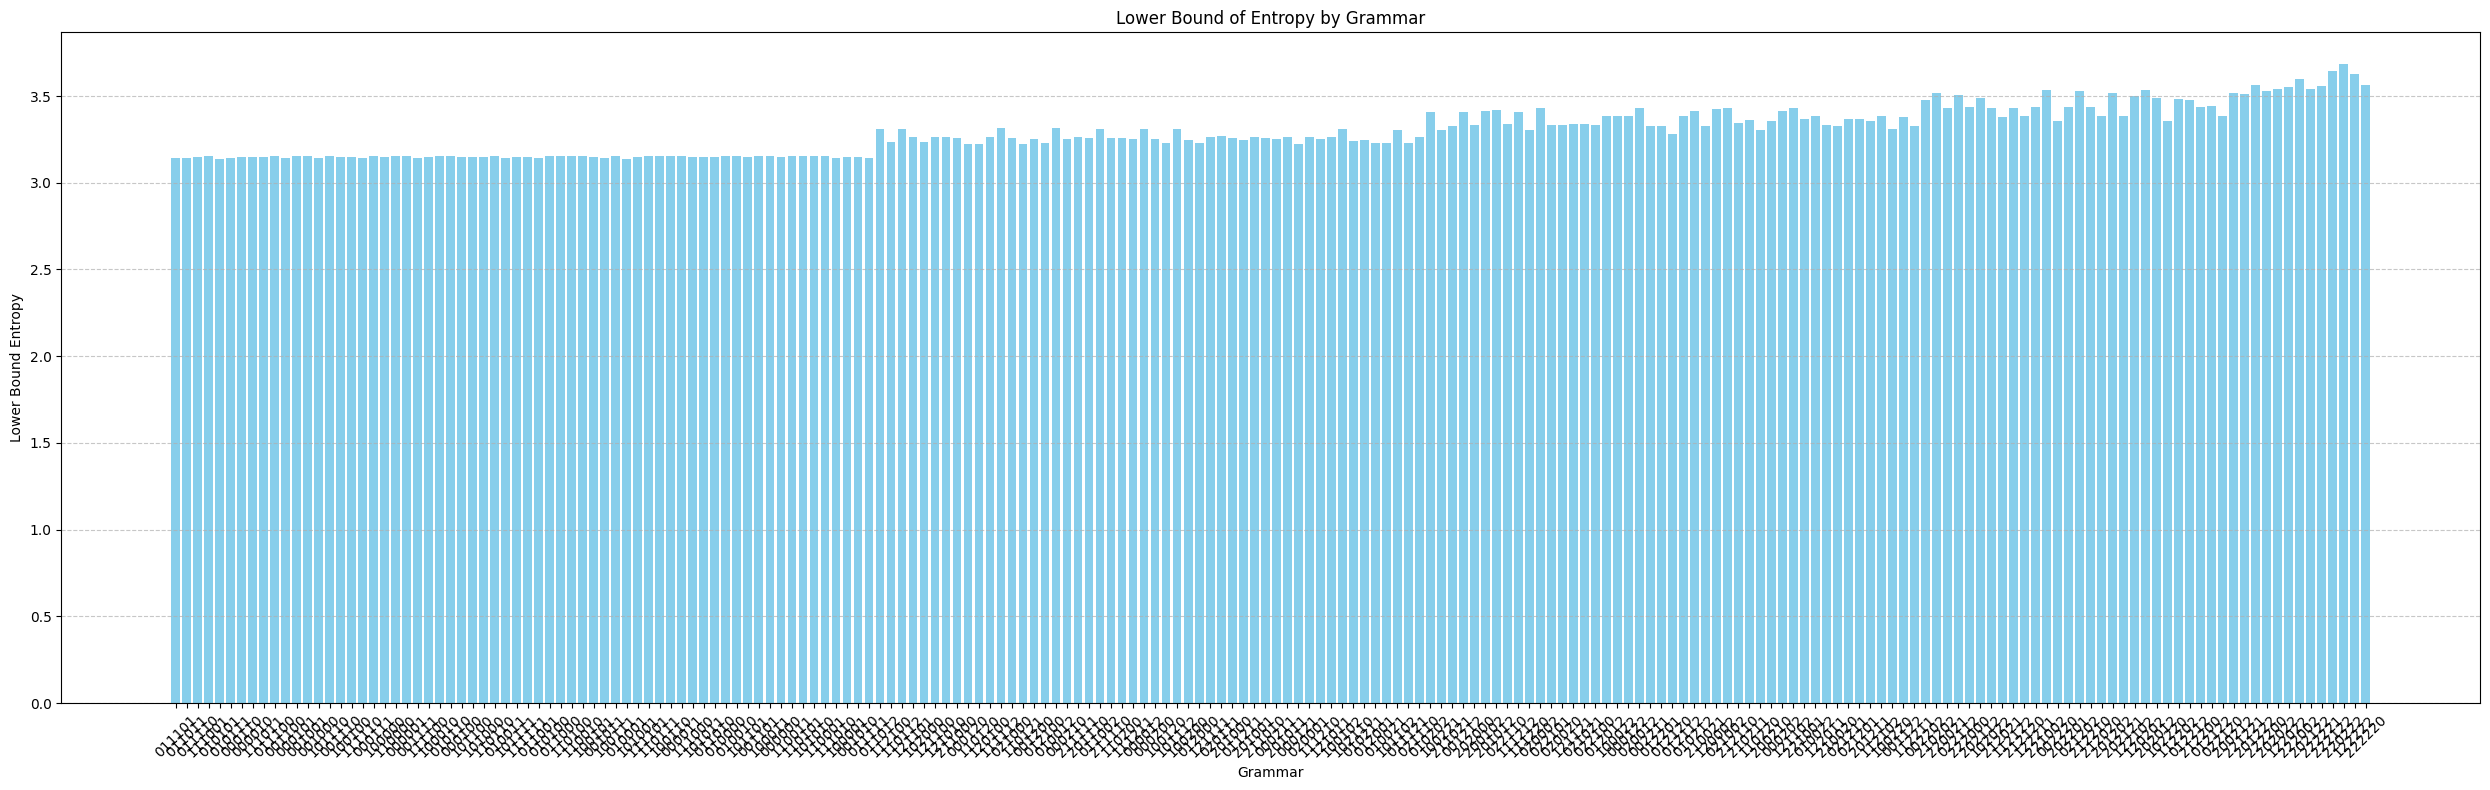

In [6]:
fig, ax = plt.subplots(figsize=(25, 8))

# プロット
ax.bar(
    lower_bound_df["grammar_name"],
    lower_bound_df["lower_bound_entropy"],  # Changed from lower_bound_perplexity
    color="skyblue",
)

# 見やすさの調整
ax.set_xticks(range(len(list(lower_bound_df["grammar_name"].values))))
ax.set_xticklabels(list(lower_bound_df["grammar_name"].values), rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Lower Bound Entropy")  # Updated ylabel
ax.set_title("Lower Bound of Entropy by Grammar")  # Updated title

# グリッドと余白の調整
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

## Lower bound entropy of testset

In [7]:
import sys

sys.path.append("..")
from src.length_sampling.sampler import construct_pcfg_sampler
from src.length_sampling.grammars.pcfg import Grammar
from src.length_sampling.grammars.cfg import Nonterminal
from src.length_sampling.lower_bound_perplexity import (
    parts_to_perplexity,
    Parts,
)
import polars as pl
from pathlib import Path
import gzip
import math
import pyarrow

In [8]:
min_length = 1
max_length = 20
data_dir = Path("../data/variations_wc/6switches_3values_min1_max20_10K")
fairseq_data_dir = Path("../data/fairseq_train/6switches_3values_min1_max20_10K")
grammar_dir = Path("../data/grammars/variations/6switches_3values")

lower_bound_complexity = []


grammar_names = lower_bound_df["grammar_name"].values
print(f"Processing {len(grammar_names)} grammars")

for grammar_name in grammar_names:
    # grammarの読み込みとsamplerの構築
    grammar_file = grammar_dir / f"{grammar_name}.gr"
    grammar = Grammar.from_file(grammar_file, Nonterminal("S"), normalize=True)
    sampler = construct_pcfg_sampler(grammar)

    true_prob_dir = data_dir / grammar_name / "true_prob"

    # テストデータの文を読み込む
    test_file = fairseq_data_dir / grammar_name / "test.txt"
    with open(test_file) as f:
        test_sentences = [line.strip() for line in f]

    # true_probデータを読み込む
    dfs = []
    for file in true_prob_dir.glob("*.csv.gz"):
        with gzip.open(file, "rt") as f:
            df = pl.read_csv(
                f, new_columns=["sentence", "count", "true_log_prob", "true_prob"]
            )
            dfs.append(df)
    if dfs:
        df = pl.concat(dfs).filter(pl.col("count").is_not_null())

        # test_sentencesをDataFrameに変換
        test_df = pd.DataFrame(test_sentences, columns=["sentence"])

        # true_log_probをtest_dfにマージ
        test_df = test_df.merge(
            df.to_pandas()[["sentence", "true_log_prob"]], on="sentence", how="left"
        )
        print(
            f"Grammar {grammar_name}, len: {len(test_df)}, unique: {test_df['sentence'].nunique()}"
        )

        # 統計量の計算
        total_neg_log_prob = -1.0 * test_df["true_log_prob"].sum()
        test_df["sent_len"] = test_df["sentence"].map(
            lambda x: len(x.split()) + 1
        )  # +1 for EOS
        total_len = test_df["sent_len"].sum()
        num_samples = len(test_df)

        valid_lengths = sampler.valid_lengths(min_length=1, max_length=20)

        # Partsを使ってパープレキシティを計算
        parts = Parts(total_neg_log_prob, total_len, num_samples)
        perplexity = parts_to_perplexity(parts, len(valid_lengths))
        entropy = math.log(perplexity)

        lower_bound_complexity.append(
            {
                "grammar_name": grammar_name,
                "lower_bound_entropy": entropy,
                "lower_bound_perplexity": perplexity,
            }
        )

Processing 200 grammars
Grammar 011101, len: 1000, unique: 1000
Grammar 011011, len: 1000, unique: 1000
Grammar 011110, len: 1000, unique: 1000
Grammar 111001, len: 1000, unique: 1000
Grammar 010101, len: 1000, unique: 1000
Grammar 010111, len: 1000, unique: 999
Grammar 000110, len: 1000, unique: 1000
Grammar 000010, len: 1000, unique: 1000
Grammar 111011, len: 1000, unique: 1000
Grammar 011100, len: 1000, unique: 1000
Grammar 001100, len: 1000, unique: 999
Grammar 000101, len: 1000, unique: 1000
Grammar 001001, len: 1000, unique: 1000
Grammar 001000, len: 1000, unique: 999
Grammar 101110, len: 1000, unique: 999
Grammar 001110, len: 1000, unique: 1000
Grammar 100100, len: 1000, unique: 1000
Grammar 111110, len: 1000, unique: 1000
Grammar 000111, len: 1000, unique: 1000
Grammar 100000, len: 1000, unique: 1000
Grammar 110000, len: 1000, unique: 1000
Grammar 000001, len: 1000, unique: 1000
Grammar 001111, len: 1000, unique: 1000
Grammar 111100, len: 1000, unique: 1000
Grammar 100010, len:

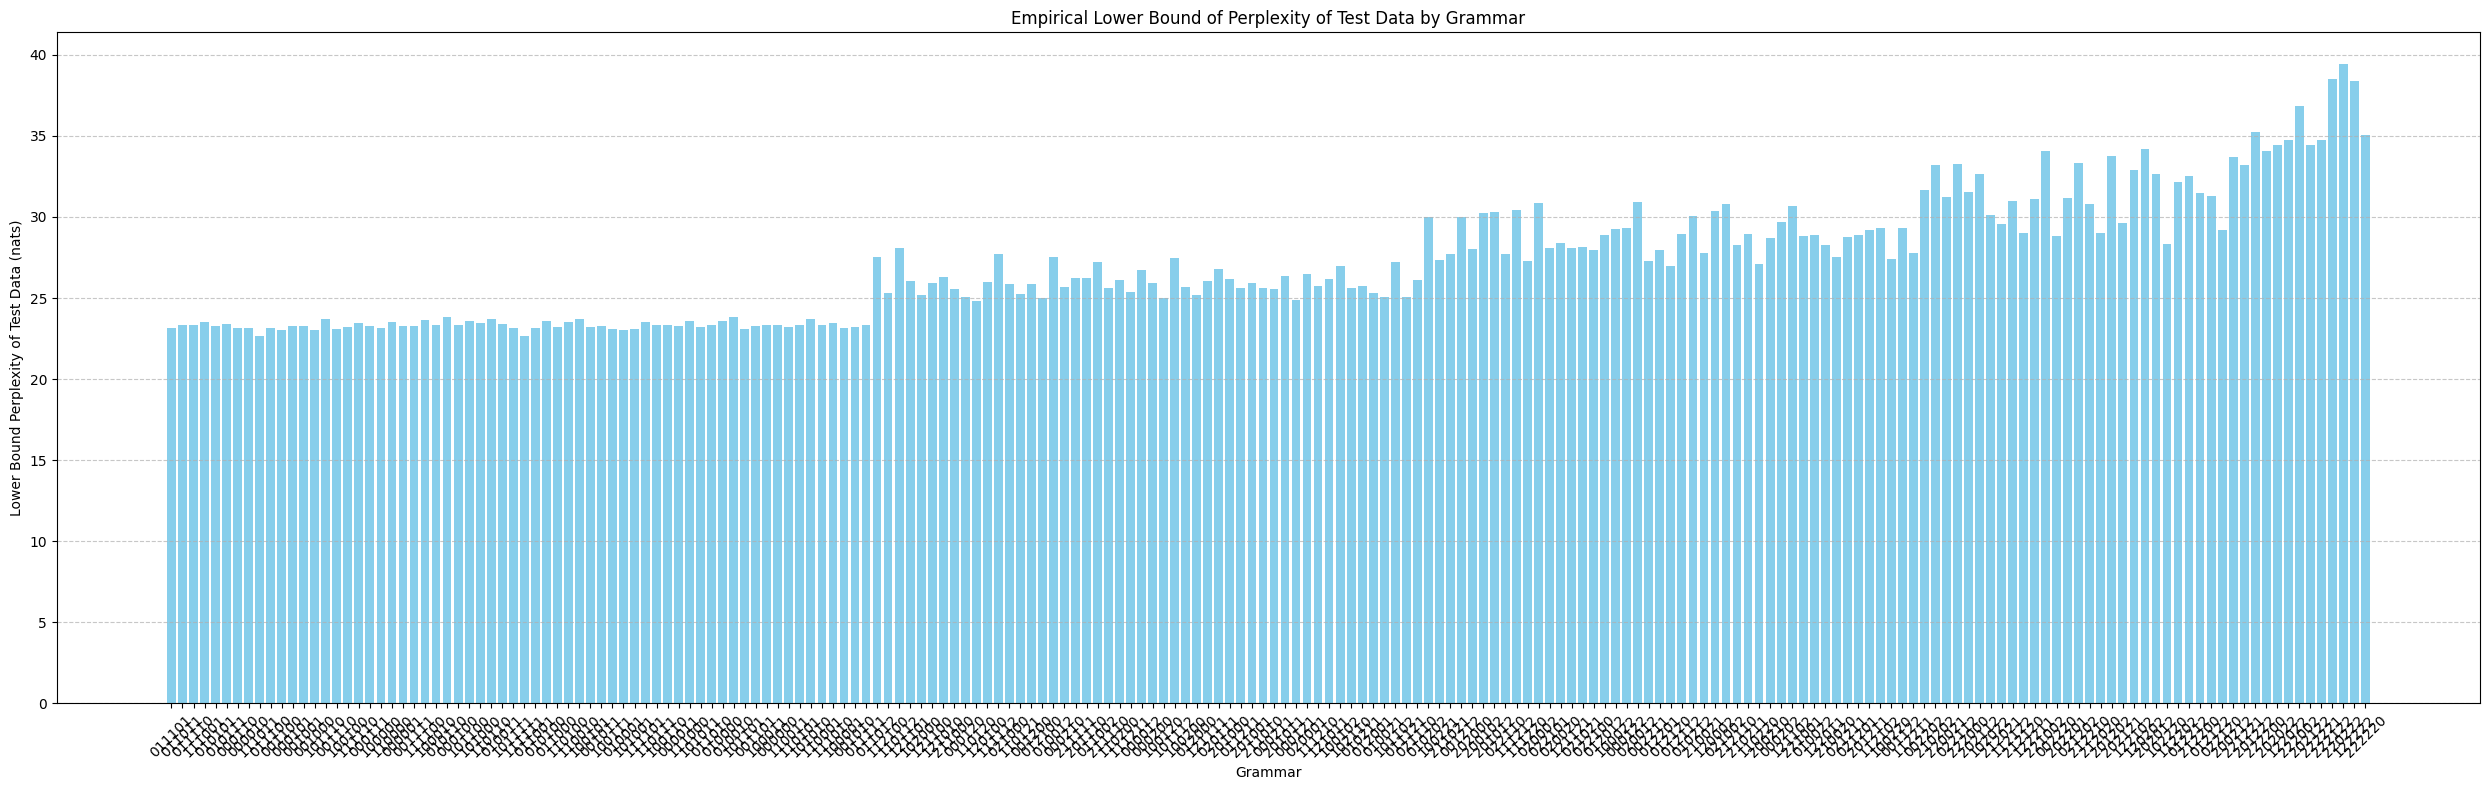

In [9]:
# 理論下限のプロット
fig, ax = plt.subplots(figsize=(25, 8))

# DataFrameに変換して扱いやすくする
lower_bound_df = pd.DataFrame(lower_bound_complexity)

# '2'の数が少ない順にソート
lower_bound_df["num_twos"] = lower_bound_df["grammar_name"].apply(
    lambda x: x.count("2")
)
lower_bound_df = lower_bound_df.sort_values(by="num_twos").drop(columns="num_twos")


# プロット
ax.bar(
    lower_bound_df["grammar_name"],
    lower_bound_df["lower_bound_perplexity"],
    color="skyblue",
)

# 見やすさの調整
ax.set_xticks(range(len(list(lower_bound_df["grammar_name"].values))))
ax.set_xticklabels(list(lower_bound_df["grammar_name"].values), rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Lower Bound Perplexity of Test Data (nats)")
ax.set_title("Empirical Lower Bound of Perplexity of Test Data by Grammar")


# グリッドと余白の調整
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

## Model performance

In [10]:
data_dir = Path("../data/fairseq_train/6switches_3values_min1_max20_10K")
grammar_names = list(lower_bound_df["grammar_name"].values)

num_seeds = 3
model_names = ["transformer", "lstm"]
results_dir = Path("../results").resolve()
exp_name = "6switches_3values_min1_max20_10K"

result_list = []
for grammar_name in tqdm(grammar_names):
    split_data_file = data_dir / grammar_name / "test.txt"
    with open(split_data_file) as f:
        total_len = sum(len(line.strip().split()) + 1 for line in f)
        # add 1 for EOS token
    for model_name in model_names:
        model_result_dir = results_dir / f"{model_name}_results" / exp_name
        grammar_result_dir = model_result_dir / f"{grammar_name}"
        # 各シードごとの統計量を保存
        seed_stats = []
        for seed_i in range(num_seeds):
            split_result_file = grammar_result_dir / f"seed{seed_i}" / "test.scores.txt"
            with open(split_result_file) as f:
                scores = [float(line.strip()) for line in f]
            neg_log_probs = [-1.0 * score for score in scores]
            entropy = sum(neg_log_probs) / total_len
            perplexity = math.exp(entropy)
            seed_stats.append({"entropy": entropy, "perplexity": perplexity})

        entropies = [s["entropy"] for s in seed_stats]
        perplexities = [s["perplexity"] for s in seed_stats]

        result_list.append(
            {
                "model_name": model_name,
                "grammar_name": grammar_name,
                "entropy_mean": np.mean(entropies),
                "entropy_std": np.std(entropies),
                "perplexity_mean": np.mean(perplexities),
                "perplexity_std": np.std(perplexities),
            }
        )

 22%|██▏       | 44/200 [00:18<00:54,  2.86it/s]

100%|██████████| 200/200 [01:14<00:00,  2.69it/s]


In [11]:
result_df = pd.DataFrame(result_list).sort_values(["model_name", "grammar_name"])
result_df

,model_name,grammar_name,entropy_mean,entropy_std,perplexity_mean,perplexity_std
111,lstm,000000,3.360132,0.001150,28.793023,0.033120
43,lstm,000001,3.385453,0.000614,29.531368,0.018120
15,lstm,000010,3.365333,0.001451,28.943157,0.041973
93,lstm,000011,3.391253,0.001484,29.703190,0.044104
177,lstm,000012,3.571455,0.003173,35.568478,0.112752
...,...,...,...,...,...,...
386,transformer,222002,4.590148,0.002601,98.509373,0.256003
392,transformer,222122,4.724042,0.004932,112.623903,0.554801
380,transformer,222200,4.364073,0.002954,78.576851,0.231880
398,transformer,222220,4.505688,0.005002,90.531698,0.452039


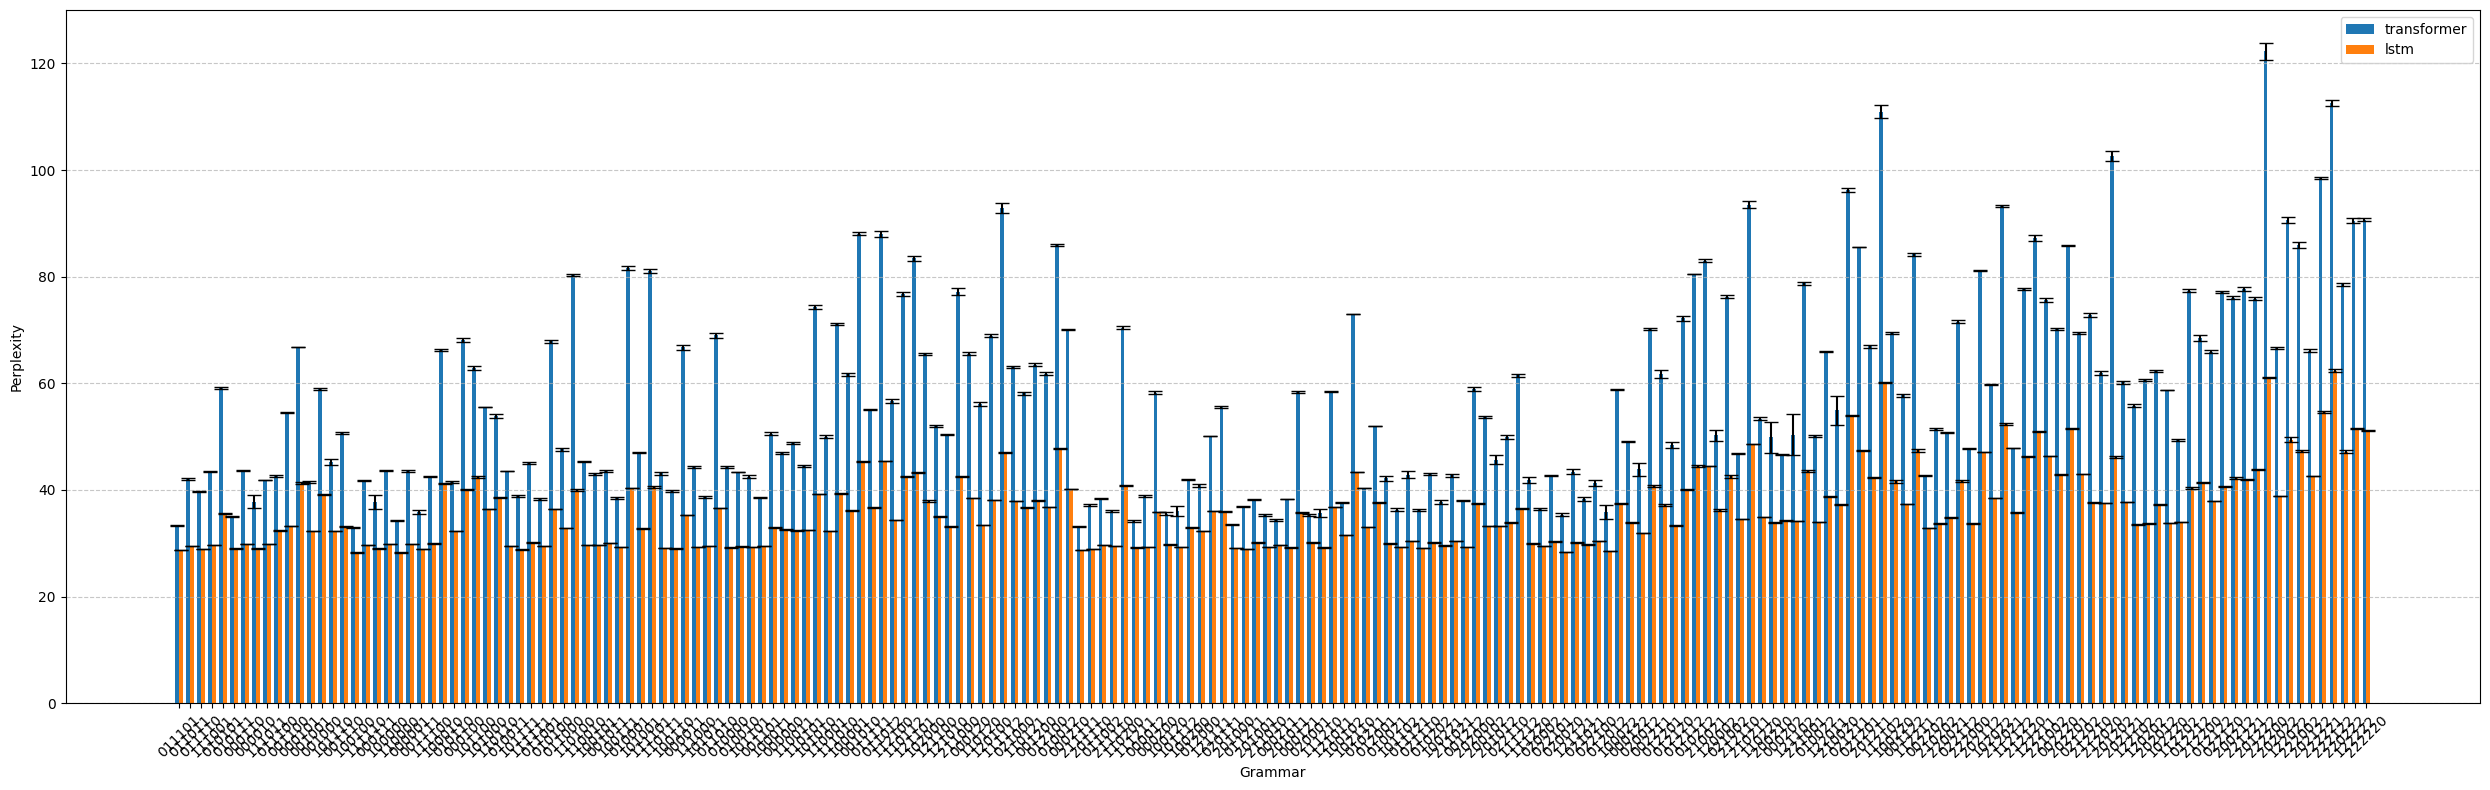

In [12]:
# plot
fig, ax = plt.subplots(figsize=(25, 8))
bar_width = 0.35

for i, model_name in enumerate(model_names):
    model_results = result_df[result_df["model_name"] == model_name]
    ax.bar(
        np.arange(len(grammar_names)) + i * bar_width,
        model_results["perplexity_mean"],
        bar_width,
        label=model_name,
        yerr=model_results["perplexity_std"],
        capsize=5,
    )

ax.set_xticks(np.arange(len(grammar_names)) + bar_width / 2)
ax.set_xticklabels(grammar_names, rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Perplexity")
ax.legend()

# グラフを見やすくする追加設定
plt.tight_layout()  # テキストの重なりを防ぐ
plt.grid(axis="y", linestyle="--", alpha=0.7)  # y軸のグリッドを追加

plt.show()

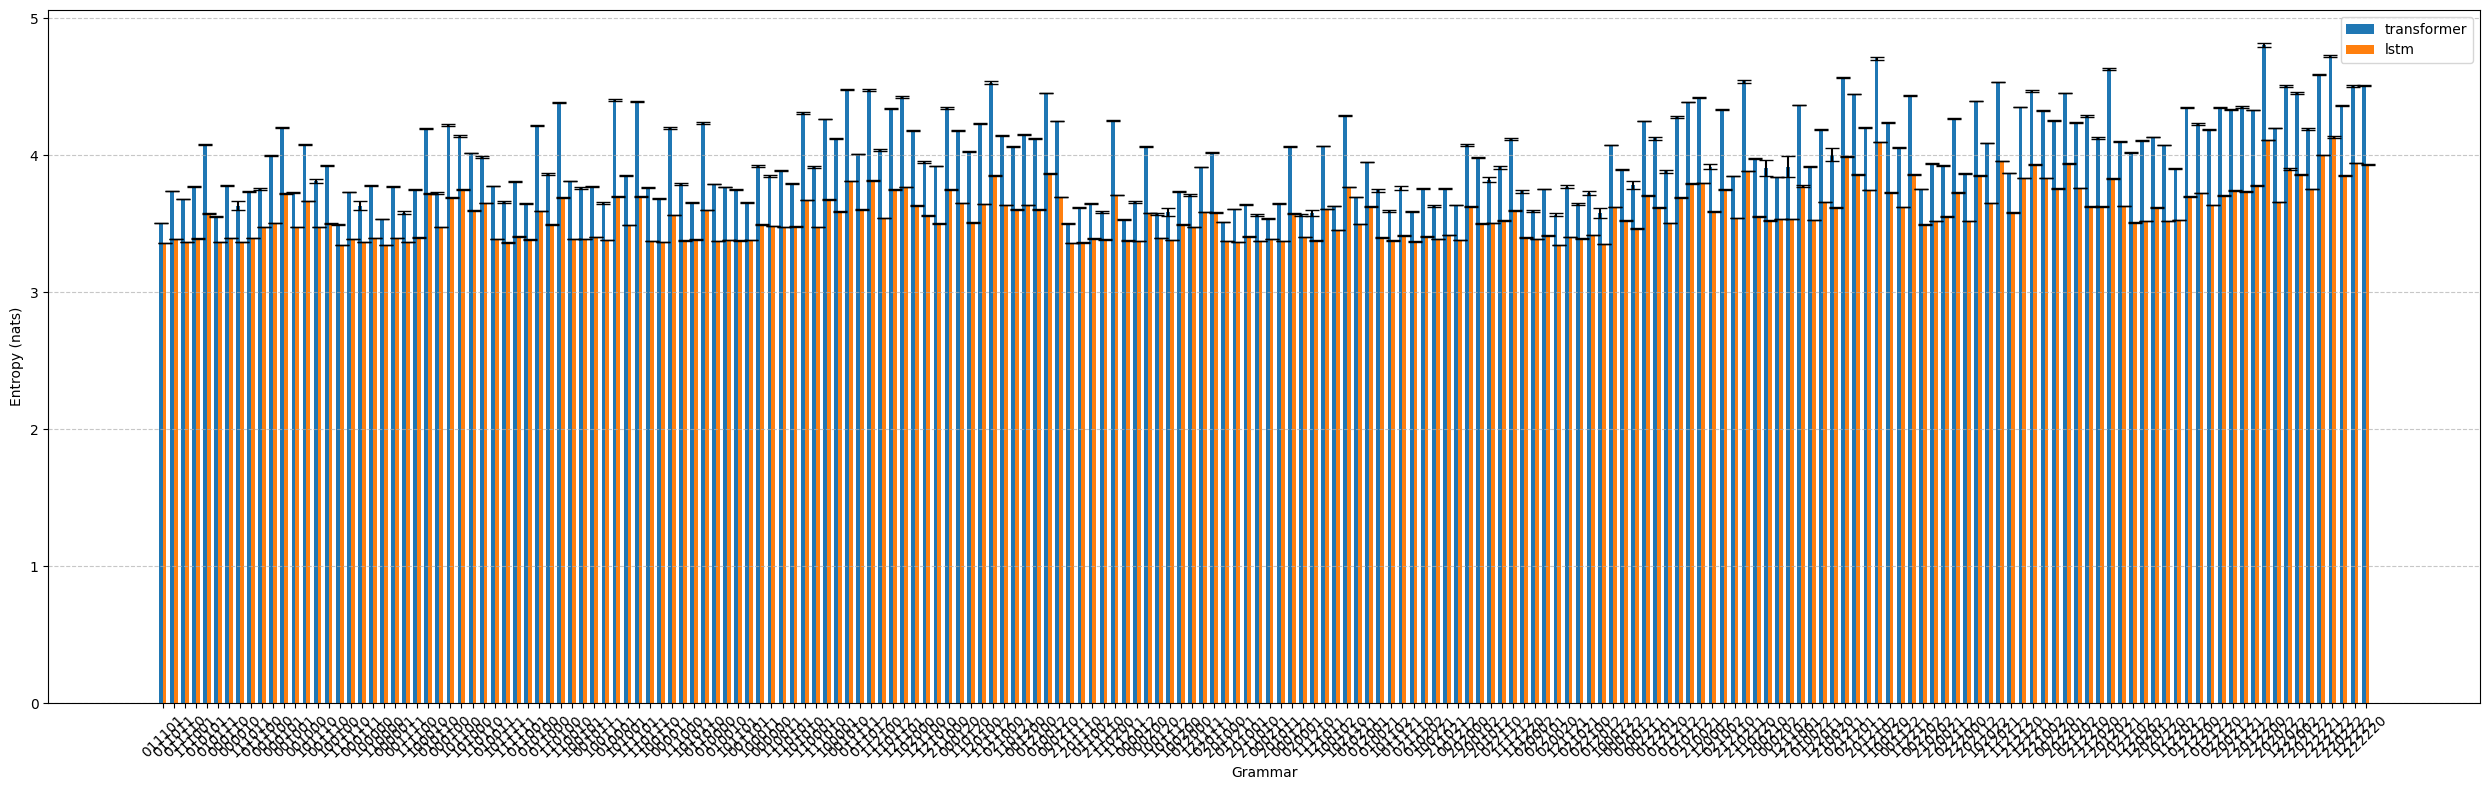

In [13]:
# plot
fig, ax = plt.subplots(figsize=(25, 8))
bar_width = 0.35

for i, model_name in enumerate(model_names):
    model_results = result_df[result_df["model_name"] == model_name]
    ax.bar(
        np.arange(len(grammar_names)) + i * bar_width,
        model_results["entropy_mean"],  # Changed from perplexity_mean
        bar_width,
        label=model_name,
        yerr=model_results["entropy_std"],  # Changed from perplexity_std
        capsize=5,
    )

ax.set_xticks(np.arange(len(grammar_names)) + bar_width / 2)
ax.set_xticklabels(grammar_names, rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Entropy (nats)")  # Updated ylabel
ax.legend()

# グラフを見やすくする追加設定
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [14]:
lower_bound_df = pd.DataFrame(lower_bound_complexity)
result_df = result_df.merge(lower_bound_df, on="grammar_name")
result_df

,model_name,grammar_name,entropy_mean,entropy_std,perplexity_mean,perplexity_std,lower_bound_entropy,lower_bound_perplexity
0,lstm,000000,3.360132,0.001150,28.793023,0.033120,3.149501,23.324411
1,lstm,000001,3.385453,0.000614,29.531368,0.018120,3.146360,23.251285
2,lstm,000010,3.365333,0.001451,28.943157,0.041973,3.142015,23.150463
3,lstm,000011,3.391253,0.001484,29.703190,0.044104,3.147521,23.278290
4,lstm,000012,3.571455,0.003173,35.568478,0.112752,3.284699,26.700956
...,...,...,...,...,...,...,...,...
395,transformer,222002,4.590148,0.002601,98.509373,0.256003,3.606091,36.821817
396,transformer,222122,4.724042,0.004932,112.623903,0.554801,3.650989,38.512726
397,transformer,222200,4.364073,0.002954,78.576851,0.231880,3.527541,34.040160
398,transformer,222220,4.505688,0.005002,90.531698,0.452039,3.557217,35.065489


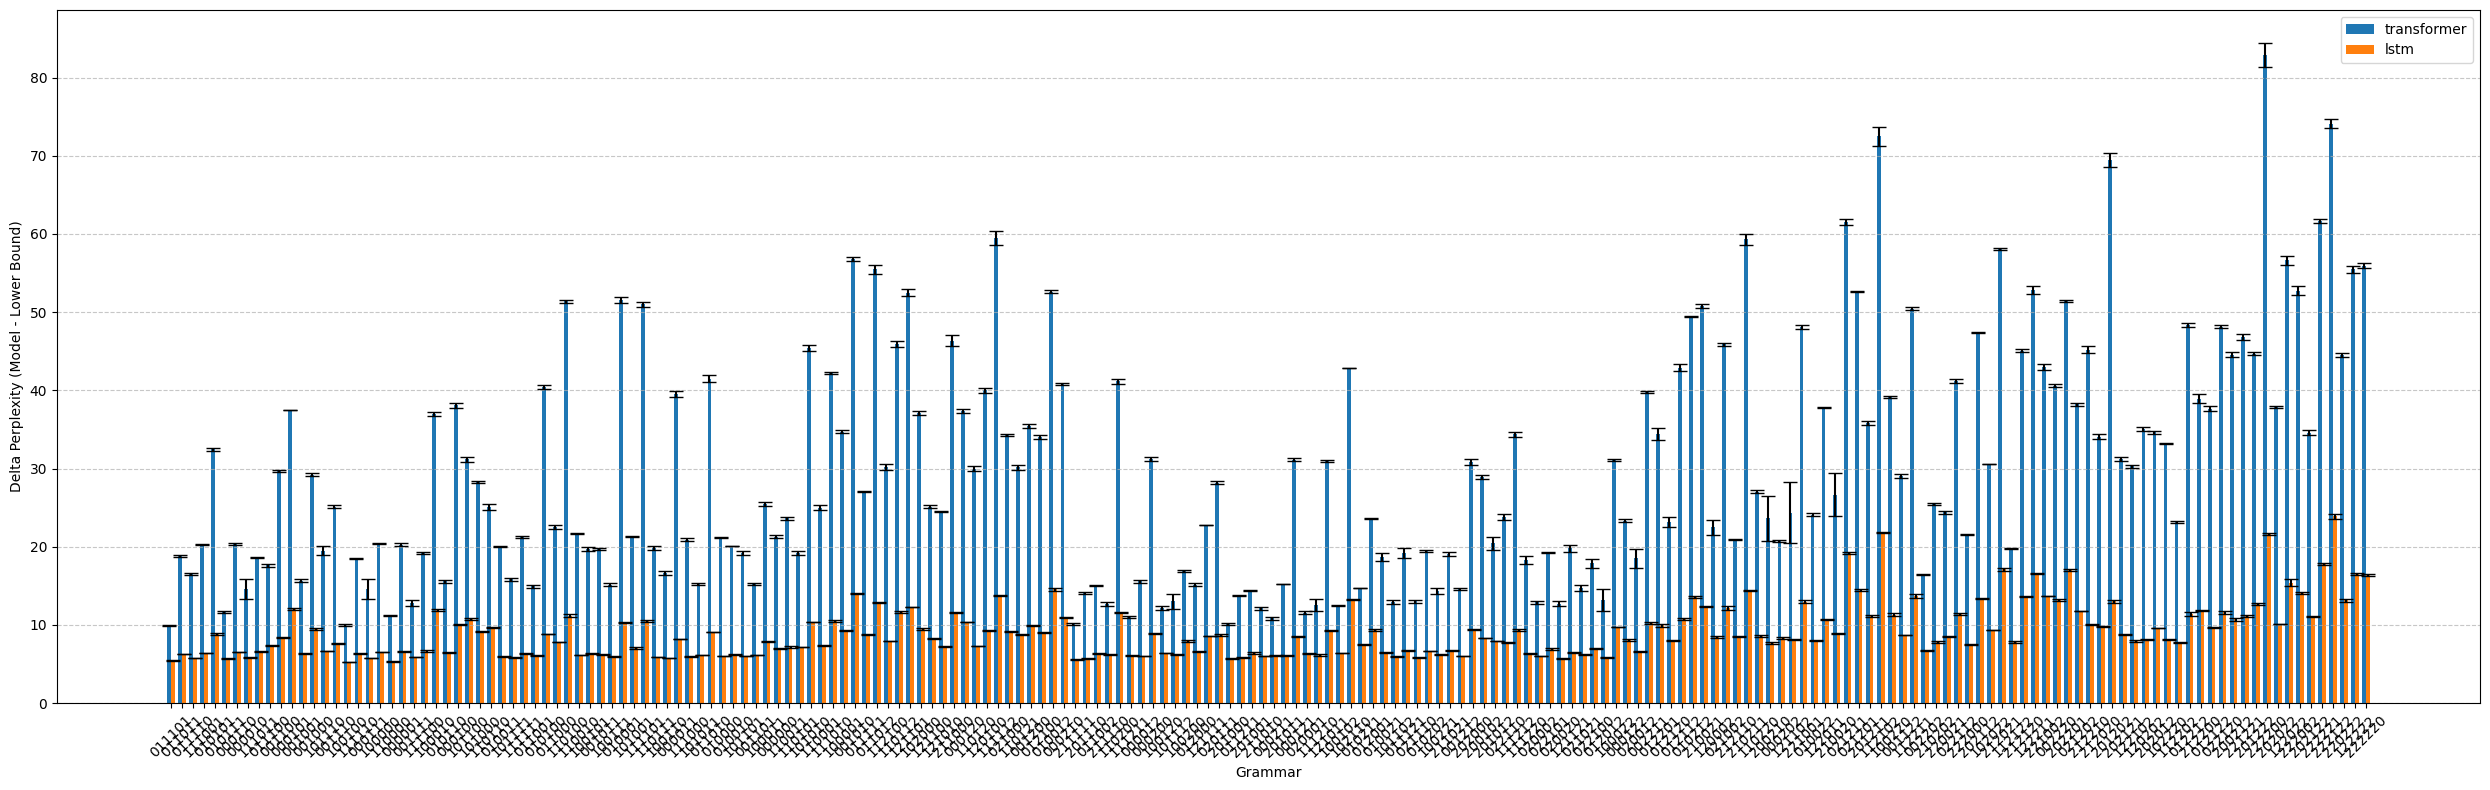

In [15]:
# plot
fig, ax = plt.subplots(figsize=(25, 8))
bar_width = 0.35

for i, model_name in enumerate(model_names):
    model_results = result_df[result_df["model_name"] == model_name]
    ax.bar(
        np.arange(len(grammar_names)) + i * bar_width,
        model_results["perplexity_mean"] - model_results["lower_bound_perplexity"],
        bar_width,
        label=model_name,
        yerr=model_results["perplexity_std"],
        capsize=5,
    )

ax.set_xticks(np.arange(len(grammar_names)) + bar_width / 2)
ax.set_xticklabels(grammar_names, rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Delta Perplexity (Model - Lower Bound)")
ax.legend()

# グラフを見やすくする追加設定
plt.tight_layout()  # テキストの重なりを防ぐ
plt.grid(axis="y", linestyle="--", alpha=0.7)  # y軸のグリッドを追加

plt.show()

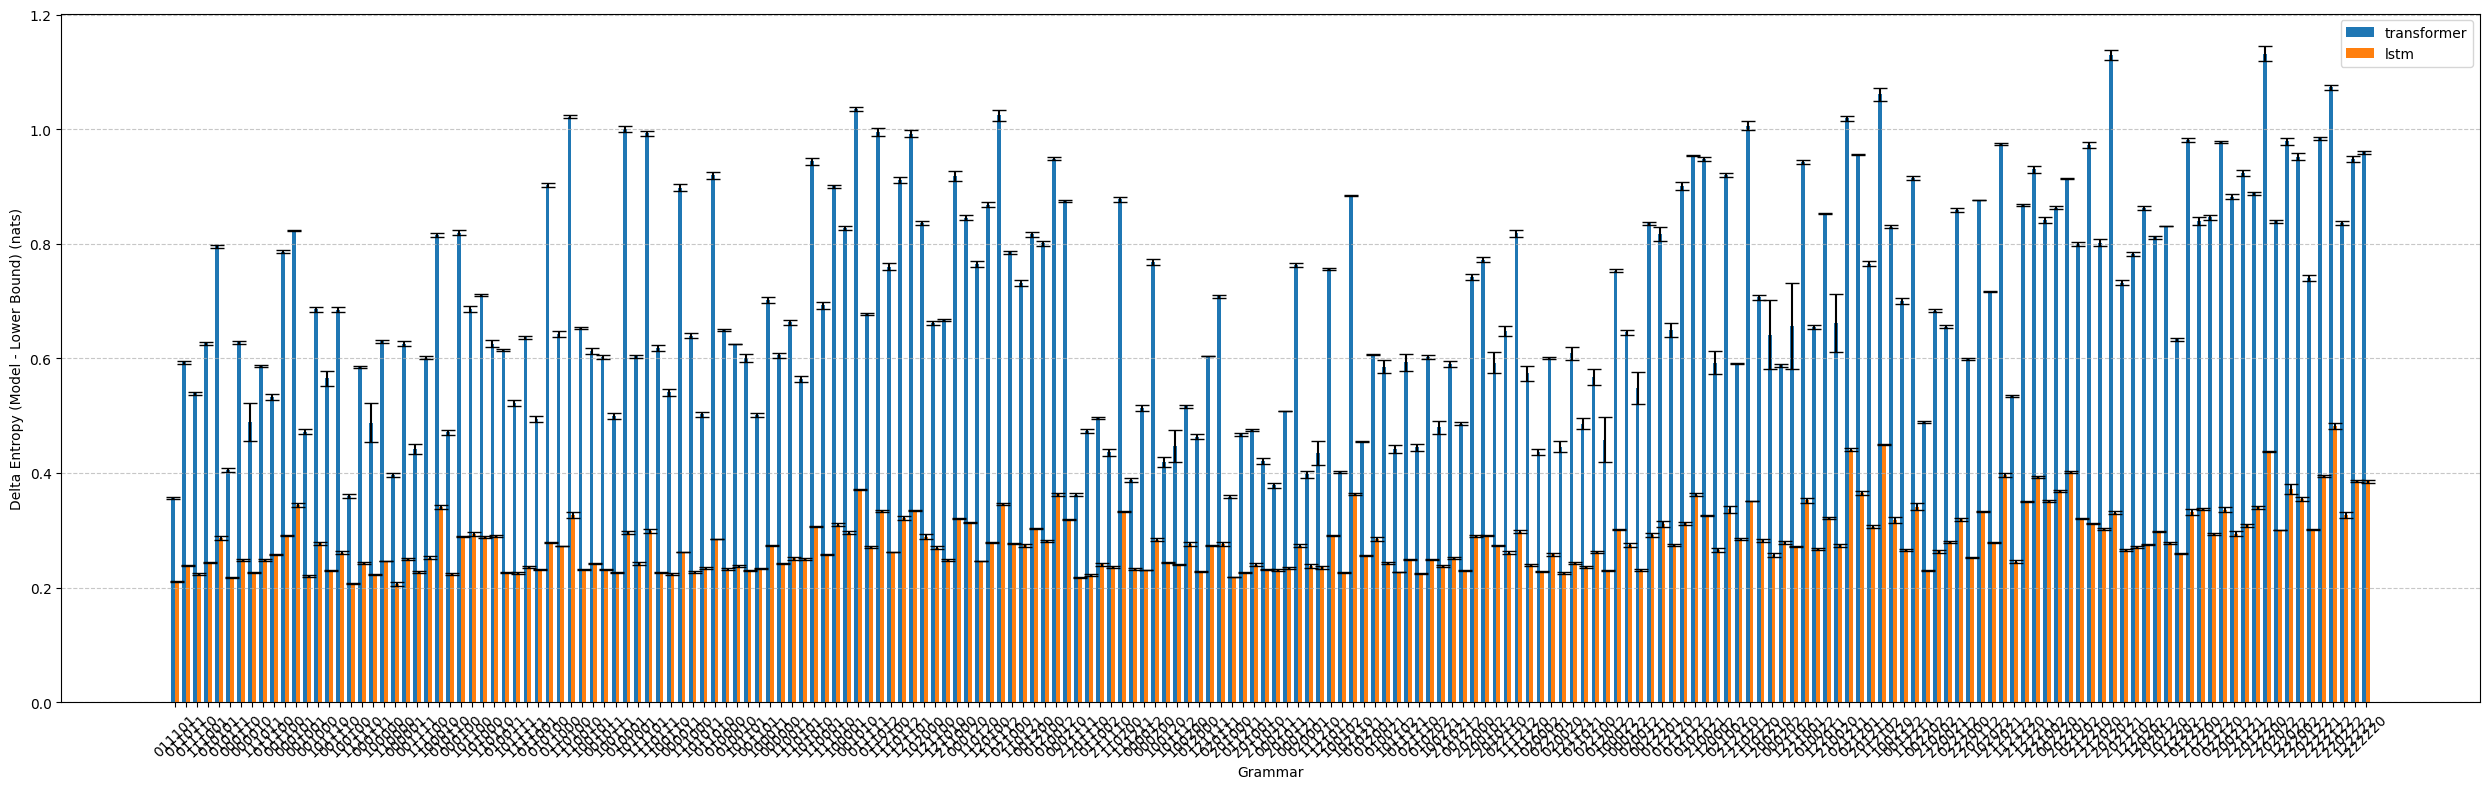

In [16]:
# plot
fig, ax = plt.subplots(figsize=(25, 8))
bar_width = 0.35

for i, model_name in enumerate(model_names):
    model_results = result_df[result_df["model_name"] == model_name]
    ax.bar(
        np.arange(len(grammar_names)) + i * bar_width,
        model_results["entropy_mean"]
        - model_results["lower_bound_entropy"],  # Changed to use entropy
        bar_width,
        label=model_name,
        yerr=model_results["entropy_std"],  # Changed to use entropy
        capsize=5,
    )

ax.set_xticks(np.arange(len(grammar_names)) + bar_width / 2)
ax.set_xticklabels(grammar_names, rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Delta Entropy (Model - Lower Bound) (nats)")  # Updated ylabel
ax.legend()

plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

### Deterministic only

In [17]:
deterministic_result_df = result_df[~result_df["grammar_name"].str.contains("2")]
deterministic_grammar_names = deterministic_result_df["grammar_name"].unique()

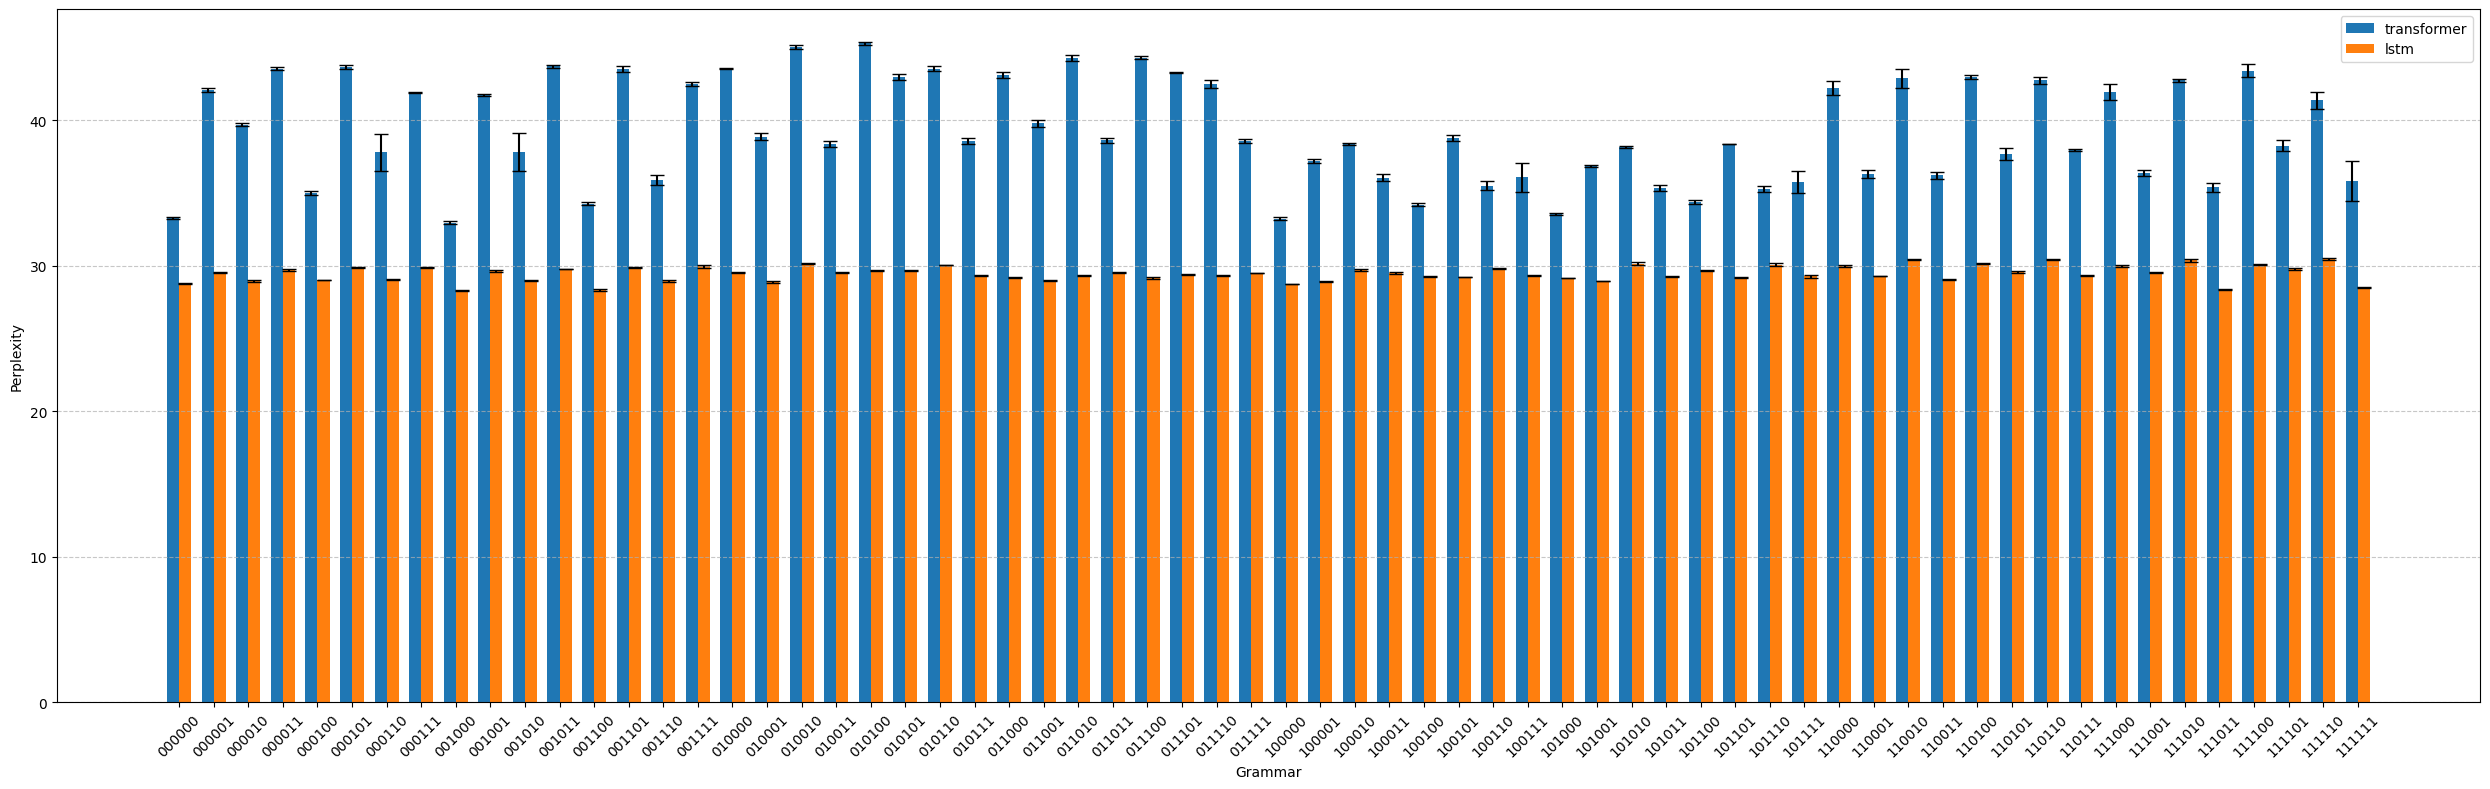

In [18]:
# plot
fig, ax = plt.subplots(figsize=(25, 8))
bar_width = 0.35

for i, model_name in enumerate(model_names):
    model_results = deterministic_result_df[
        deterministic_result_df["model_name"] == model_name
    ]
    ax.bar(
        np.arange(len(deterministic_grammar_names)) + i * bar_width,
        model_results["perplexity_mean"],
        bar_width,
        label=model_name,
        yerr=model_results["perplexity_std"],
        capsize=5,
    )

ax.set_xticks(np.arange(len(deterministic_grammar_names)) + bar_width / 2)
ax.set_xticklabels(deterministic_grammar_names, rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Perplexity")
ax.legend()

# グラフを見やすくする追加設定
plt.tight_layout()  # テキストの重なりを防ぐ
plt.grid(axis="y", linestyle="--", alpha=0.7)  # y軸のグリッドを追加

plt.show()

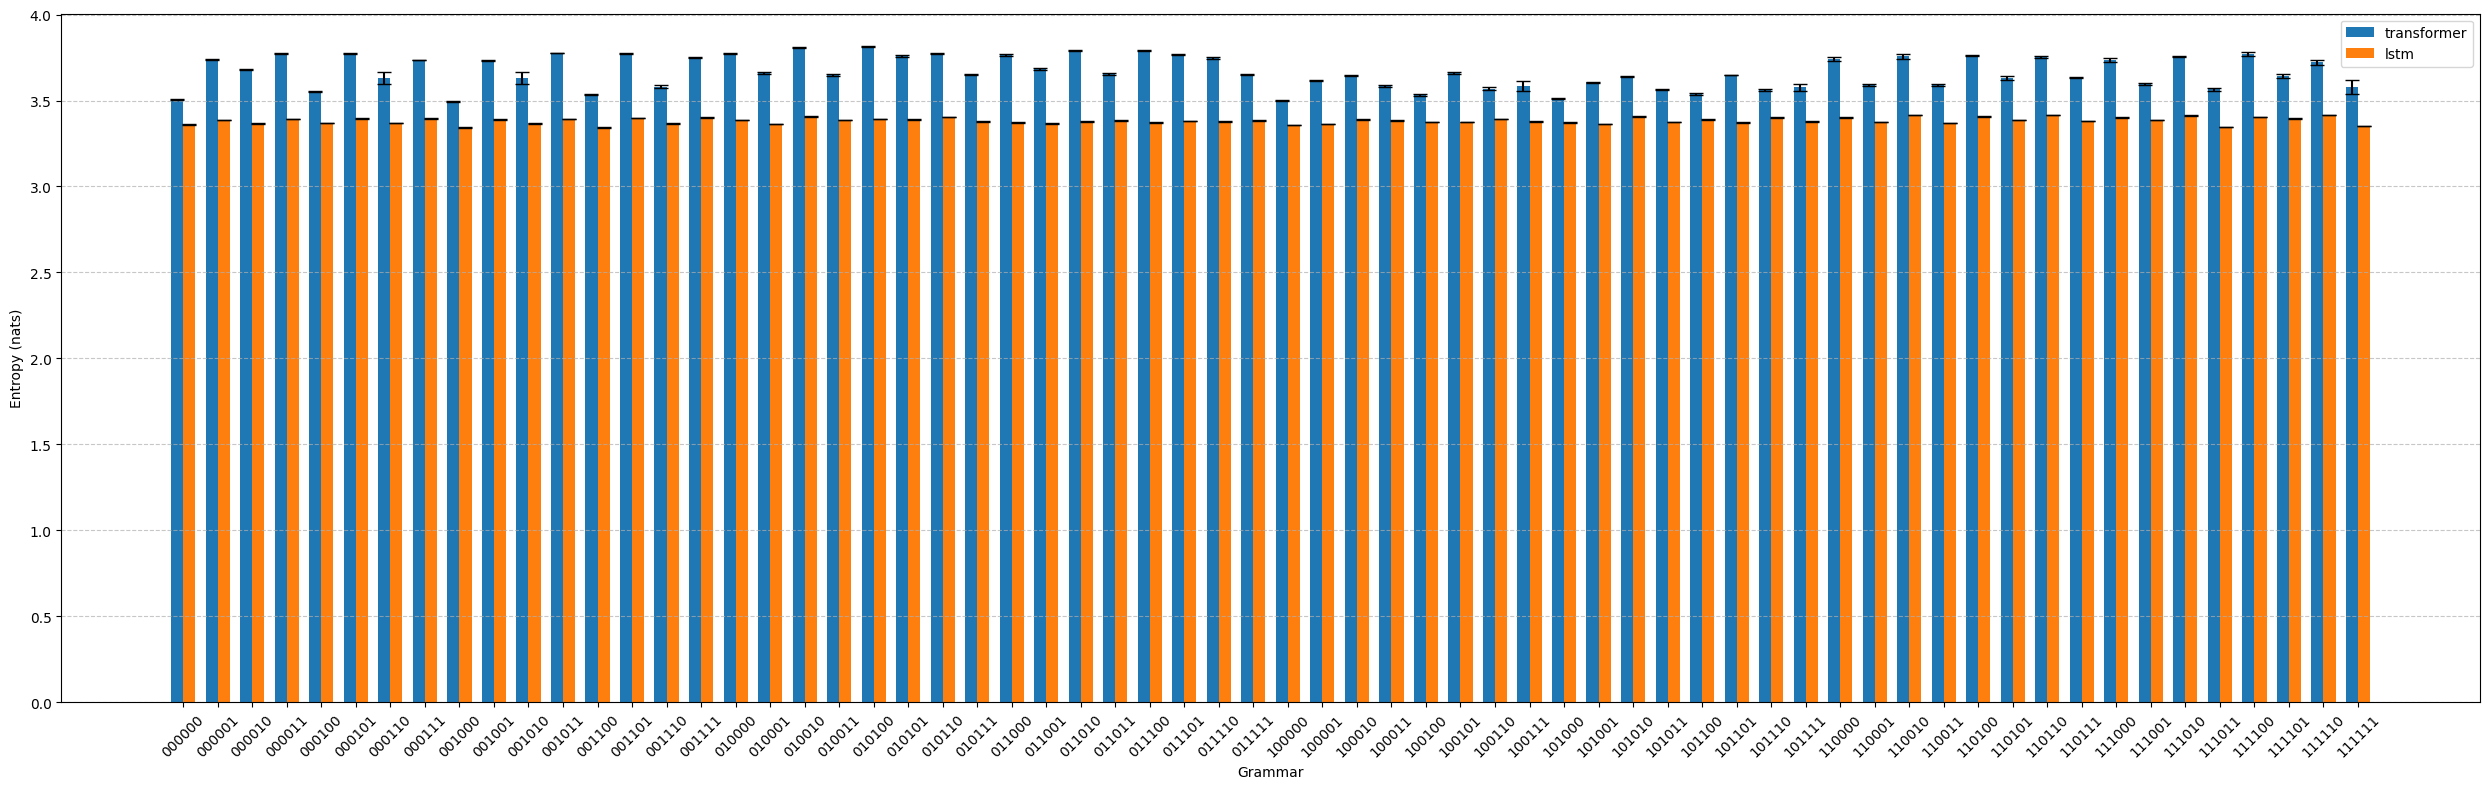

In [19]:
# plot
fig, ax = plt.subplots(figsize=(25, 8))
bar_width = 0.35

for i, model_name in enumerate(model_names):
    model_results = deterministic_result_df[
        deterministic_result_df["model_name"] == model_name
    ]
    ax.bar(
        np.arange(len(deterministic_grammar_names)) + i * bar_width,
        model_results["entropy_mean"],  # Changed from perplexity_mean
        bar_width,
        label=model_name,
        yerr=model_results["entropy_std"],  # Changed from perplexity_std
        capsize=5,
    )

ax.set_xticks(np.arange(len(deterministic_grammar_names)) + bar_width / 2)
ax.set_xticklabels(deterministic_grammar_names, rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Entropy (nats)")  # Updated ylabel
ax.legend()

# グラフを見やすくする追加設定
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

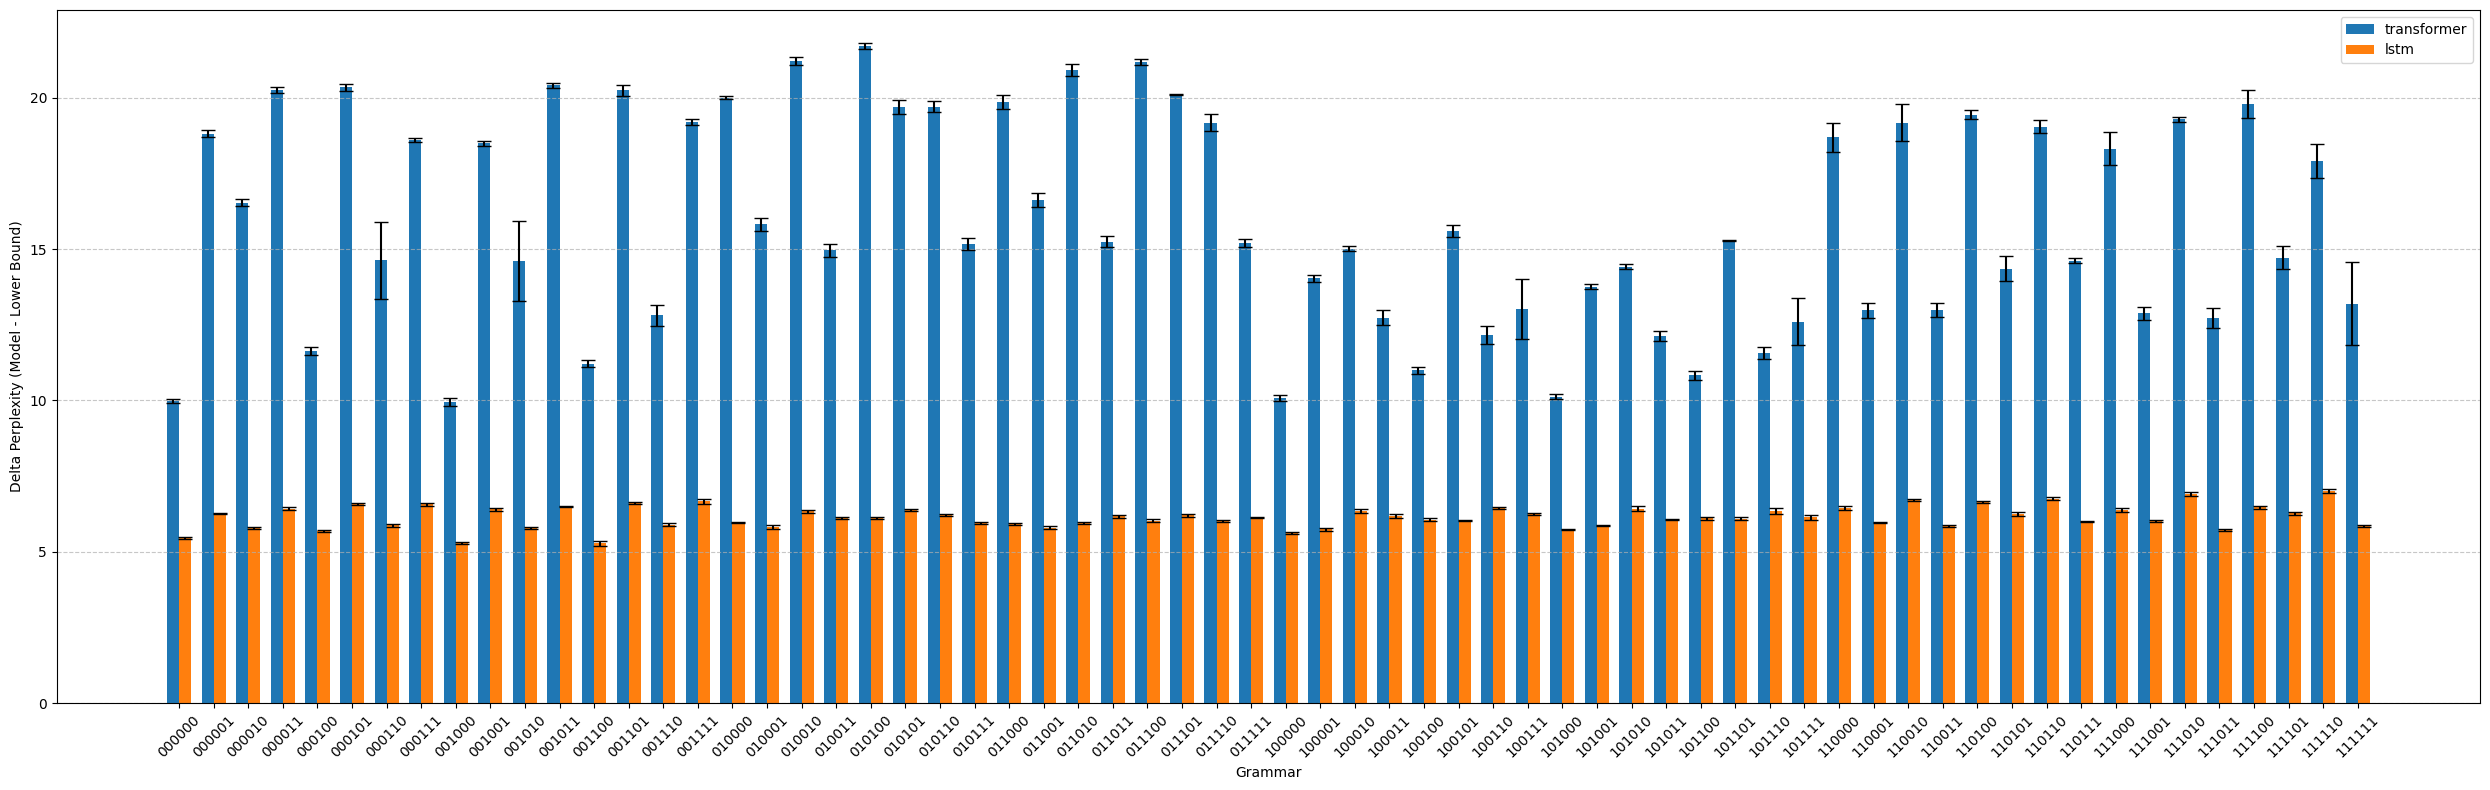

In [20]:
# plot
fig, ax = plt.subplots(figsize=(25, 8))
bar_width = 0.35

for i, model_name in enumerate(model_names):
    model_results = deterministic_result_df[
        deterministic_result_df["model_name"] == model_name
    ]
    ax.bar(
        np.arange(len(deterministic_grammar_names)) + i * bar_width,
        model_results["perplexity_mean"] - model_results["lower_bound_perplexity"],
        bar_width,
        label=model_name,
        yerr=model_results["perplexity_std"],
        capsize=5,
    )

ax.set_xticks(np.arange(len(deterministic_grammar_names)) + bar_width / 2)
ax.set_xticklabels(deterministic_grammar_names, rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Delta Perplexity (Model - Lower Bound)")
ax.legend()

# グラフを見やすくする追加設定
plt.tight_layout()  # テキストの重なりを防ぐ
plt.grid(axis="y", linestyle="--", alpha=0.7)  # y軸のグリッドを追加

plt.show()

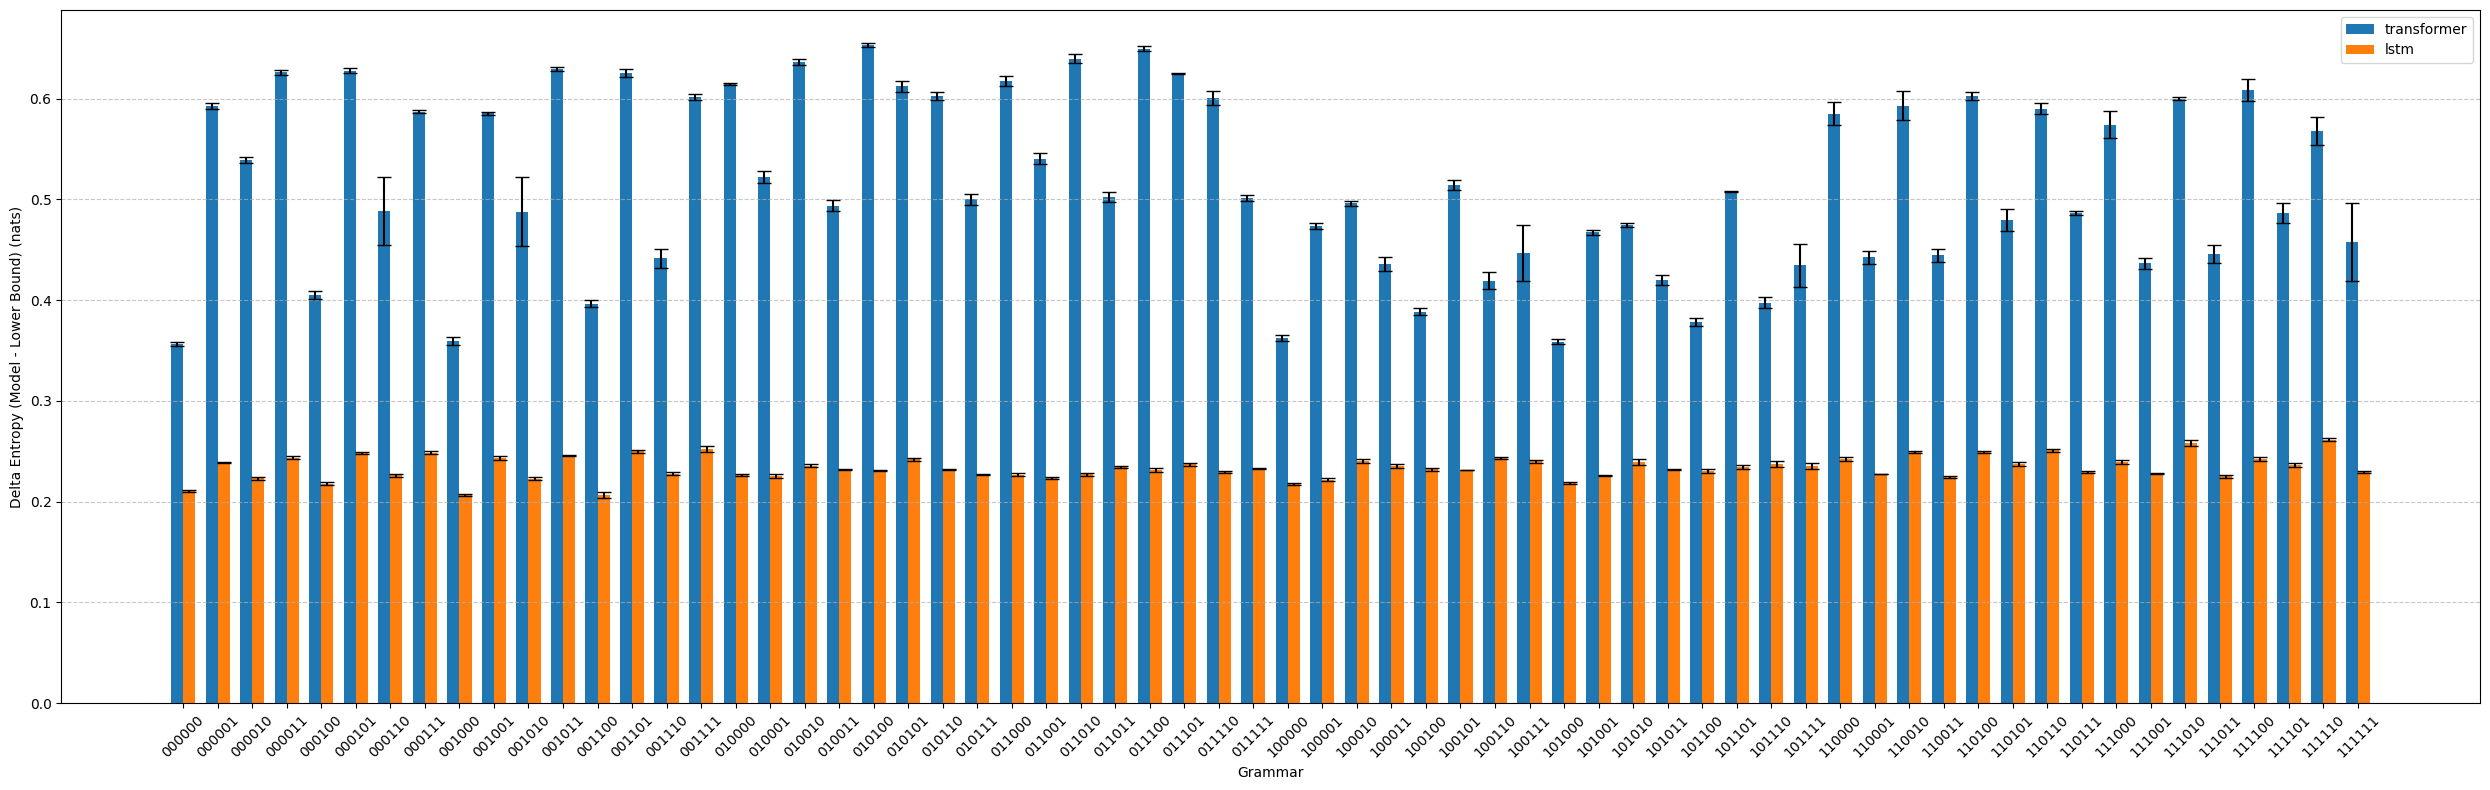

In [21]:
# plot
fig, ax = plt.subplots(figsize=(25, 8))
bar_width = 0.35

for i, model_name in enumerate(model_names):
    model_results = deterministic_result_df[
        deterministic_result_df["model_name"] == model_name
    ]
    ax.bar(
        np.arange(len(deterministic_grammar_names)) + i * bar_width,
        model_results["entropy_mean"]
        - model_results["lower_bound_entropy"],  # Changed to use entropy
        bar_width,
        label=model_name,
        yerr=model_results["entropy_std"],  # Changed to use entropy
        capsize=5,
    )

ax.set_xticks(np.arange(len(deterministic_grammar_names)) + bar_width / 2)
ax.set_xticklabels(deterministic_grammar_names, rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Delta Entropy (Model - Lower Bound) (nats)")  # Updated ylabel
ax.legend()

plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Lower bound complexity of data x model performance

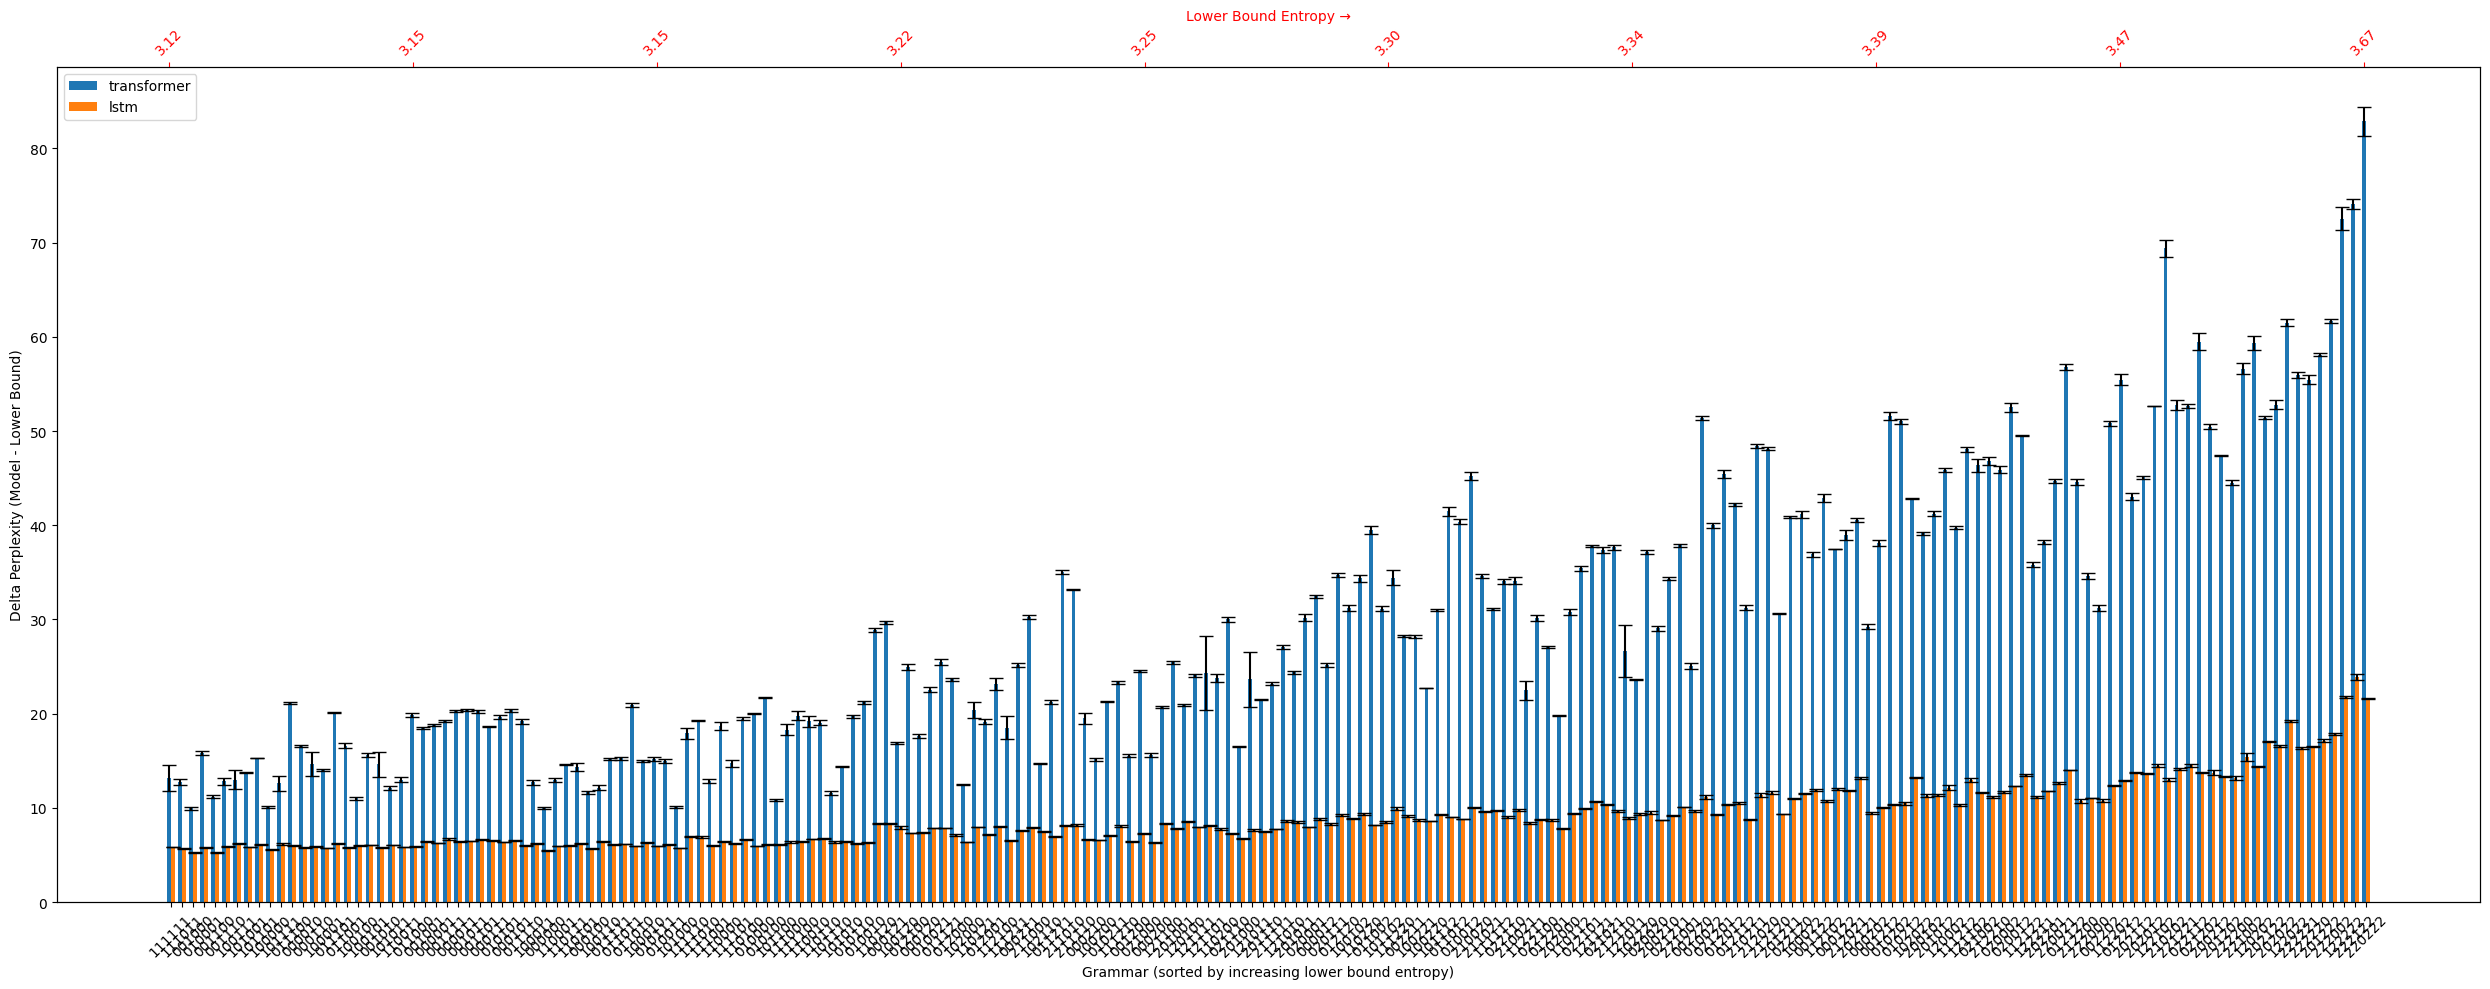

In [22]:
# Sort grammar names by lower_bound_entropy
sorted_indices = (
    result_df[result_df["model_name"] == model_names[0]]
    .sort_values("lower_bound_entropy")
    .index
)
sorted_grammar_names = result_df.loc[sorted_indices, "grammar_name"].values
sorted_entropies = result_df.loc[sorted_indices, "lower_bound_entropy"].values

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(25, 10))
ax2 = ax1.twiny()  # Create a twin axis sharing the y-axis
bar_width = 0.35

# Plot bars on the main axis
for i, model_name in enumerate(model_names):
    model_results = result_df[result_df["model_name"] == model_name].sort_values(
        "lower_bound_entropy"
    )
    ax1.bar(
        np.arange(len(sorted_grammar_names)) + i * bar_width,
        model_results["perplexity_mean"] - model_results["lower_bound_perplexity"],
        bar_width,
        label=model_name,
        yerr=model_results["perplexity_std"],
        capsize=5,
    )

# Main axis settings
ax1.set_xticks(np.arange(len(sorted_grammar_names)) + bar_width / 2)
ax1.set_xticklabels(sorted_grammar_names, rotation=45)
ax1.set_xlabel("Grammar (sorted by increasing lower bound entropy)")
ax1.set_ylabel("Delta Perplexity (Model - Lower Bound)")
ax1.legend()

# Twin axis settings (showing entropy values)
ax2.set_xlim(ax1.get_xlim())
num_ticks = 10  # Adjust this number to control how many entropy values to show
tick_positions = np.linspace(0, len(sorted_grammar_names) - 1, num_ticks)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(
    [f"{sorted_entropies[int(pos)]:.2f}" for pos in tick_positions], rotation=45
)
ax2.set_xlabel("Lower Bound Entropy →", color="red")
ax2.tick_params(axis="x", colors="red")

# グラフを見やすくする追加設定
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

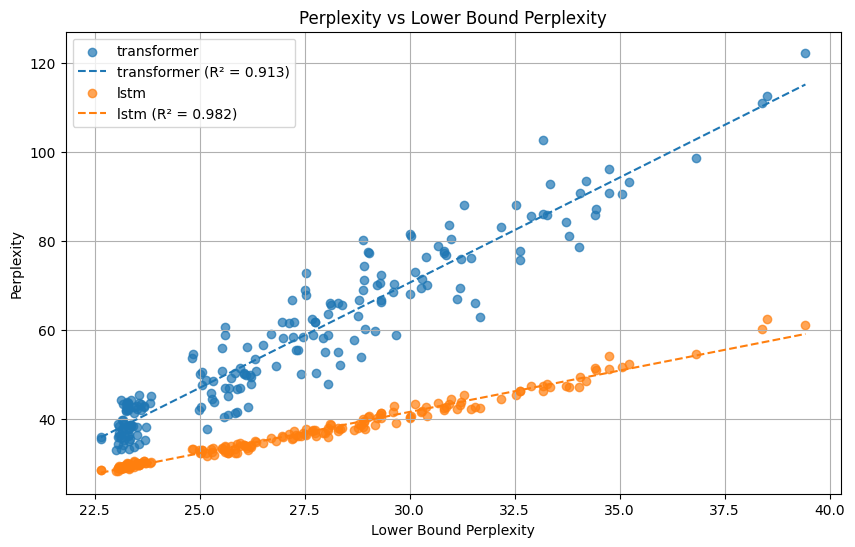

In [23]:
plt.figure(figsize=(10, 6))

for model_name in model_names:
    model_results = result_df[result_df["model_name"] == model_name]
    x = model_results["lower_bound_perplexity"]
    y = model_results["perplexity_mean"]

    # 散布図をプロット
    plt.scatter(x, y, label=model_name, alpha=0.7)

    # 回帰直線を計算
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.array([min(x), max(x)])
    line_y = slope * line_x + intercept

    # 回帰直線をプロット
    plt.plot(line_x, line_y, "--", label=f"{model_name} (R² = {r_value**2:.3f})")

plt.xlabel("Lower Bound Perplexity")
plt.ylabel("Perplexity")
plt.title("Perplexity vs Lower Bound Perplexity")
plt.legend()
plt.grid(True)
plt.show()

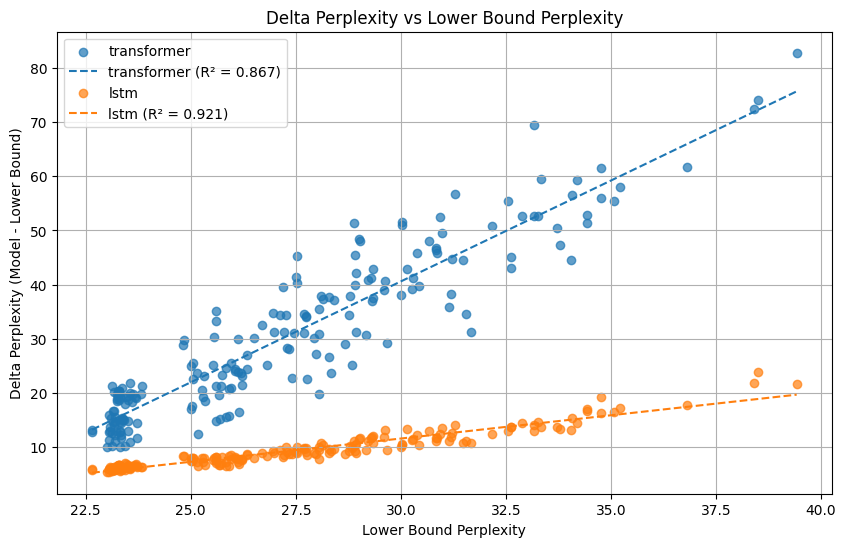

In [24]:
plt.figure(figsize=(10, 6))

for model_name in model_names:
    model_results = result_df[result_df["model_name"] == model_name]
    x = model_results["lower_bound_perplexity"]
    y = model_results["perplexity_mean"] - model_results["lower_bound_perplexity"]

    # 散布図をプロット
    plt.scatter(x, y, label=model_name, alpha=0.7)

    # 回帰直線を計算
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.array([min(x), max(x)])
    line_y = slope * line_x + intercept

    # 回帰直線をプロット
    plt.plot(line_x, line_y, "--", label=f"{model_name} (R² = {r_value**2:.3f})")

plt.xlabel("Lower Bound Perplexity")
plt.ylabel("Delta Perplexity (Model - Lower Bound)")
plt.title("Delta Perplexity vs Lower Bound Perplexity")
plt.legend()
plt.grid(True)
plt.show()

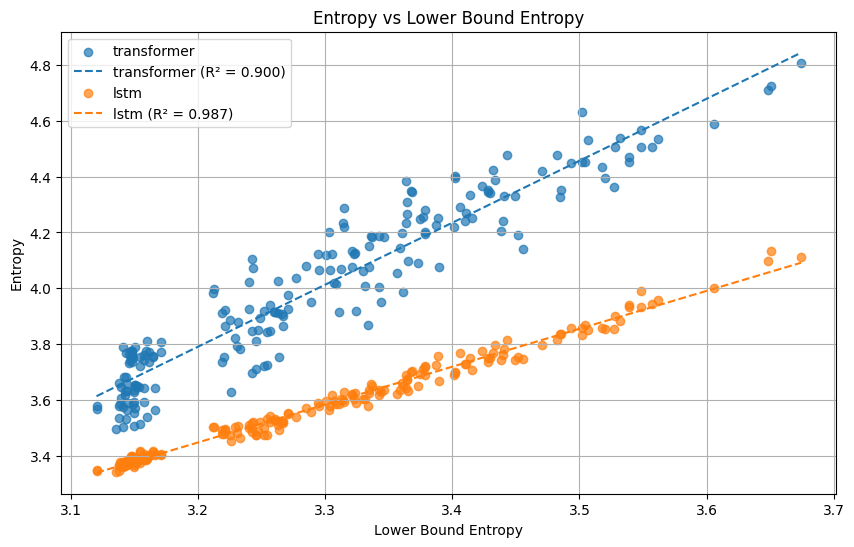

In [25]:
plt.figure(figsize=(10, 6))

for model_name in model_names:
    model_results = result_df[result_df["model_name"] == model_name]
    x = model_results["lower_bound_entropy"]
    y = model_results["entropy_mean"]

    # 散布図をプロット
    plt.scatter(x, y, label=model_name, alpha=0.7)

    # 回帰直線を計算
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.array([min(x), max(x)])
    line_y = slope * line_x + intercept

    # 回帰直線をプロット
    plt.plot(line_x, line_y, "--", label=f"{model_name} (R² = {r_value**2:.3f})")

plt.xlabel("Lower Bound Entropy")
plt.ylabel("Entropy")
plt.title("Entropy vs Lower Bound Entropy")
plt.legend()
plt.grid(True)

plt.show()

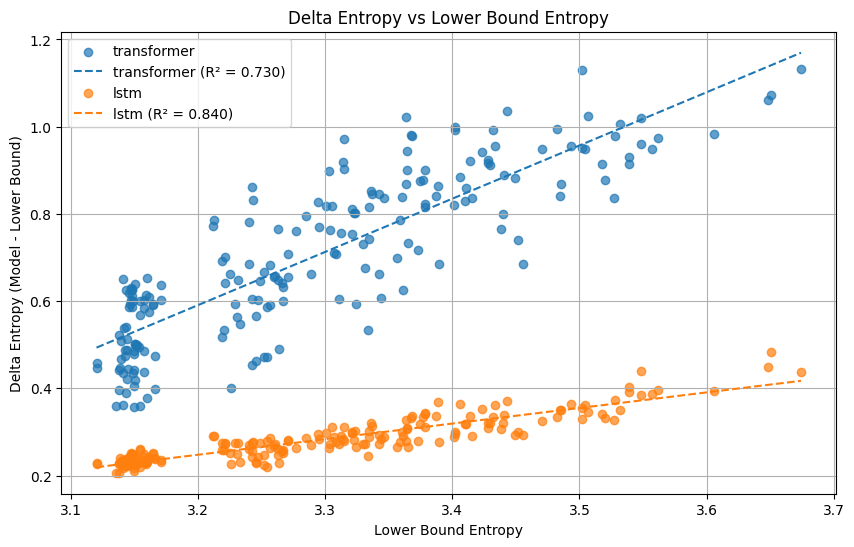

In [26]:
plt.figure(figsize=(10, 6))

for model_name in model_names:
    model_results = result_df[result_df["model_name"] == model_name]
    x = model_results["lower_bound_entropy"]
    y = model_results["entropy_mean"] - model_results["lower_bound_entropy"]

    # 散布図をプロット
    plt.scatter(x, y, label=model_name, alpha=0.7)

    # 回帰直線を計算
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.array([min(x), max(x)])
    line_y = slope * line_x + intercept

    # 回帰直線をプロット
    plt.plot(line_x, line_y, "--", label=f"{model_name} (R² = {r_value**2:.3f})")

plt.xlabel("Lower Bound Entropy")
plt.ylabel("Delta Entropy (Model - Lower Bound)")
plt.title("Delta Entropy vs Lower Bound Entropy")
plt.legend()
plt.grid(True)
plt.show()

## Language plausibility x model performance plot (deterministic)

In [27]:
import json

lang2freq_path = "../data/lang2freq.json"
with open(lang2freq_path) as f:
    lang2freq = json.load(f)
lang2freq = {lang.replace("2", ""): score for lang, score in lang2freq.items()}
lang2freq = {k: v for k, v in sorted(lang2freq.items(), key=lambda x: x[1])}
lang2freq

{'101001': 0.0006188118811881188,
 '101011': 0.0006768254950495049,
 '101101': 0.0011215965346534653,
 '100001': 0.0011796101485148514,
 '101000': 0.0012569616336633664,
 '110001': 0.0016243811881188118,
 '100011': 0.0016243811881188118,
 '101010': 0.0017017326732673267,
 '101100': 0.001875773514851485,
 '110101': 0.0019337871287128713,
 '100101': 0.0019918007425742575,
 '101111': 0.0021851794554455448,
 '110011': 0.0021851794554455448,
 '100111': 0.0025912747524752477,
 '100000': 0.002900680693069307,
 '100100': 0.003210086633663366,
 '101110': 0.0033261138613861385,
 '001011': 0.0035388304455445546,
 '110000': 0.0036161819306930695,
 '010001': 0.003635519801980198,
 '110100': 0.003654857673267327,
 '001001': 0.0037902227722772276,
 '010011': 0.004118966584158416,
 '110111': 0.004428372524752475,
 '100010': 0.00466042698019802,
 '111101': 0.004931157178217822,
 '100110': 0.004969832920792079,
 '111001': 0.005163211633663367,
 '011001': 0.005279238861386139,
 '110010': 0.00618811881188

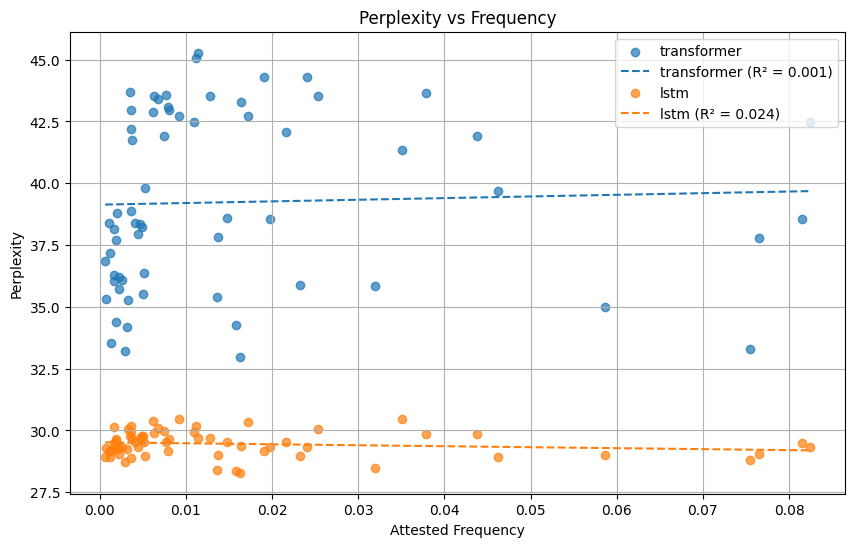

In [28]:
filtered_result_df = result_df[~result_df["grammar_name"].str.contains("2")]

plt.figure(figsize=(10, 6))

for model_name in model_names:
    model_results = filtered_result_df[filtered_result_df["model_name"] == model_name]
    x = [lang2freq[grammar_name] for grammar_name in model_results["grammar_name"]]
    y = model_results["perplexity_mean"]

    # 散布図をプロット
    plt.scatter(x, y, label=model_name, alpha=0.7)

    # 回帰直線を計算
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.array([min(x), max(x)])
    line_y = slope * line_x + intercept

    # 回帰直線をプロット
    plt.plot(line_x, line_y, "--", label=f"{model_name} (R² = {r_value**2:.3f})")

plt.xlabel("Attested Frequency")
plt.ylabel("Perplexity")
plt.title("Perplexity vs Frequency")
plt.legend()
plt.grid(True)
plt.show()

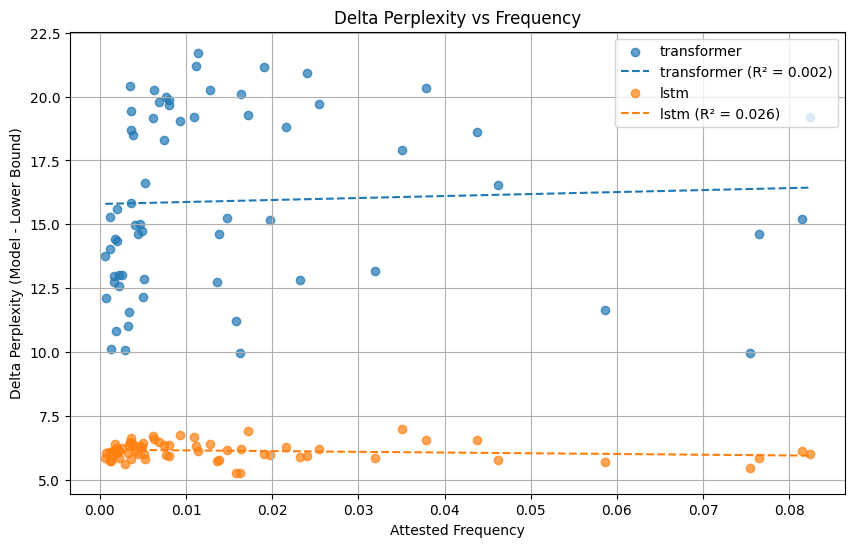

In [29]:
plt.figure(figsize=(10, 6))

for model_name in model_names:
    model_results = filtered_result_df[filtered_result_df["model_name"] == model_name]
    x = [lang2freq[grammar_name] for grammar_name in model_results["grammar_name"]]
    y = model_results["perplexity_mean"] - model_results["lower_bound_perplexity"]

    # 散布図をプロット
    plt.scatter(x, y, label=model_name, alpha=0.7)

    # 回帰直線を計算
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.array([min(x), max(x)])
    line_y = slope * line_x + intercept

    # 回帰直線をプロット
    plt.plot(line_x, line_y, "--", label=f"{model_name} (R² = {r_value**2:.3f})")

plt.xlabel("Attested Frequency")
plt.ylabel("Delta Perplexity (Model - Lower Bound)")
plt.title("Delta Perplexity vs Frequency")
plt.legend()
plt.grid(True)
plt.show()

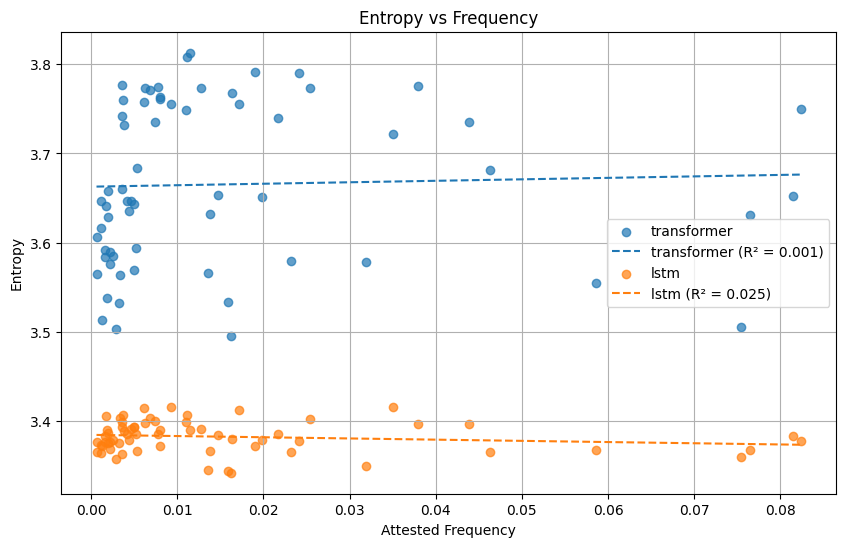

In [30]:
filtered_result_df = result_df[~result_df["grammar_name"].str.contains("2")]

plt.figure(figsize=(10, 6))

for model_name in model_names:
    model_results = filtered_result_df[filtered_result_df["model_name"] == model_name]
    x = [lang2freq[grammar_name] for grammar_name in model_results["grammar_name"]]
    y = model_results["entropy_mean"]

    # 散布図をプロット
    plt.scatter(x, y, label=model_name, alpha=0.7)

    # 回帰直線を計算
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.array([min(x), max(x)])
    line_y = slope * line_x + intercept

    # 回帰直線をプロット
    plt.plot(line_x, line_y, "--", label=f"{model_name} (R² = {r_value**2:.3f})")

plt.xlabel("Attested Frequency")
plt.ylabel("Entropy")
plt.title("Entropy vs Frequency")
plt.legend()

plt.grid(True)
plt.show()

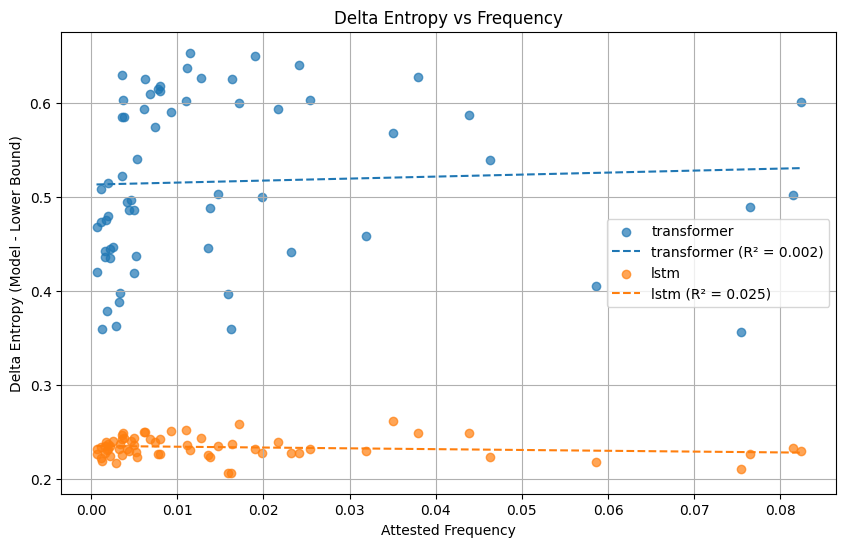

In [31]:
plt.figure(figsize=(10, 6))

for model_name in model_names:
    model_results = filtered_result_df[filtered_result_df["model_name"] == model_name]
    x = [lang2freq[grammar_name] for grammar_name in model_results["grammar_name"]]
    y = model_results["entropy_mean"] - model_results["lower_bound_entropy"]

    # 散布図をプロット
    plt.scatter(x, y, label=model_name, alpha=0.7)

    # 回帰直線を計算
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.array([min(x), max(x)])
    line_y = slope * line_x + intercept

    # 回帰直線をプロット
    plt.plot(line_x, line_y, "--", label=f"{model_name} (R² = {r_value**2:.3f})")

plt.xlabel("Attested Frequency")
plt.ylabel("Delta Entropy (Model - Lower Bound)")
plt.title("Delta Entropy vs Frequency")
plt.legend()
plt.grid(True)
plt.show()

### Canonical word order (and its prevalence) x model performance

In [32]:
def grammar_name_to_svo_order(grammar_name):
    tag = grammar_name[:2]
    if tag == "00":
        return "SOV"
    elif tag == "01":
        return "SVO"
    elif tag == "10":
        return "OVS"
    elif tag == "11":
        return "VOS"
    else:
        raise ValueError(f"Invalid tag: {tag}")

/tmp/ipykernel_1939423/3061419204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result_df["word_order"] = filtered_result_df["grammar_name"].apply(


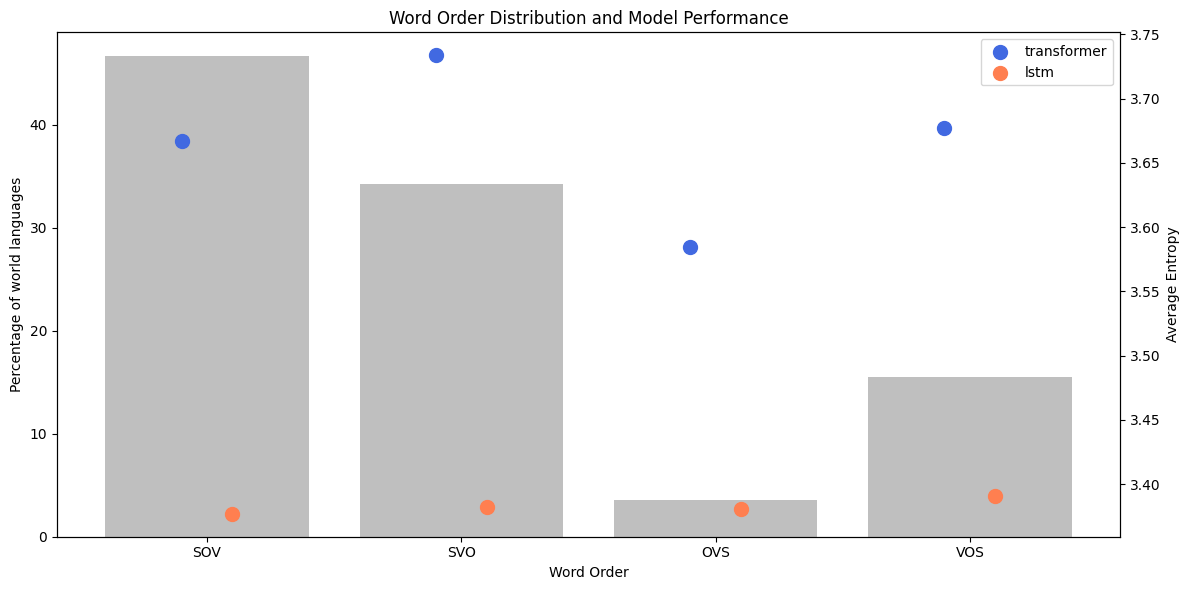

In [33]:
# データの準備
filtered_result_df = result_df[~result_df["grammar_name"].str.contains("2")]
filtered_result_df["word_order"] = filtered_result_df["grammar_name"].apply(
    grammar_name_to_svo_order
)

# 語順ごとの頻度を計算
word_order_freqs = {}
for word_order in ["SOV", "SVO", "OVS", "VOS"]:
    # その語順を持つ文法の頻度の合計
    total_freq = sum(
        lang2freq[grammar_name]
        for grammar_name in filtered_result_df[
            filtered_result_df["word_order"] == word_order
        ]["grammar_name"].unique()
    )
    word_order_freqs[word_order] = total_freq * 100  # パーセンテージに変換

# プロットの作成
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()  # 二つ目のy軸を作成

# 棒グラフ（頻度）
word_orders = ["SOV", "SVO", "OVS", "VOS"]
bars = ax1.bar(
    word_orders, [word_order_freqs[wo] for wo in word_orders], alpha=0.5, color="gray"
)

# 散布図（パフォーマンス）
width = 0.2  # 点をずらす幅
colors = {"lstm": "coral", "transformer": "royalblue"}

for i, model_name in enumerate(model_names):
    model_means = []
    for word_order in word_orders:
        mask = (filtered_result_df["model_name"] == model_name) & (
            filtered_result_df["word_order"] == word_order
        )
        mean_entropy = filtered_result_df[mask]["entropy_mean"].mean()
        model_means.append(mean_entropy)

    # 各語順の位置を少しずらして点をプロット
    positions = np.arange(len(word_orders)) + (i - 0.5) * width
    ax2.scatter(
        positions, model_means, color=colors[model_name], label=model_name, s=100
    )

# 軸の設定
ax1.set_ylabel("Percentage of world languages")
ax2.set_ylabel("Average Entropy")
ax1.set_xlabel("Word Order")

# 凡例
lines1, labels1 = ax2.get_legend_handles_labels()
ax2.legend(lines1, labels1, loc="upper right")

plt.title("Word Order Distribution and Model Performance")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1939423/404268946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result_df["word_order"] = filtered_result_df["grammar_name"].apply(


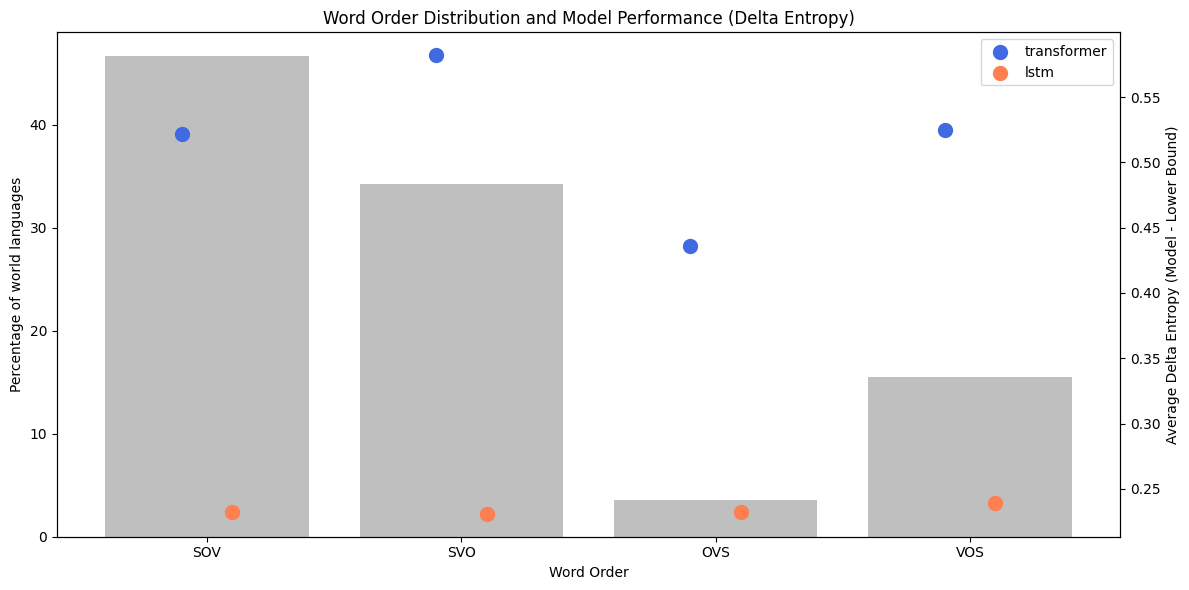

In [34]:
# データの準備
filtered_result_df = result_df[~result_df["grammar_name"].str.contains("2")]
filtered_result_df["word_order"] = filtered_result_df["grammar_name"].apply(
    grammar_name_to_svo_order
)

# 語順ごとの頻度を計算
word_order_freqs = {}
for word_order in ["SOV", "SVO", "OVS", "VOS"]:
    total_freq = sum(
        lang2freq[grammar_name]
        for grammar_name in filtered_result_df[
            filtered_result_df["word_order"] == word_order
        ]["grammar_name"].unique()
    )
    word_order_freqs[word_order] = total_freq * 100

# プロットの作成
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# 棒グラフ（頻度）
word_orders = ["SOV", "SVO", "OVS", "VOS"]
bars = ax1.bar(
    word_orders, [word_order_freqs[wo] for wo in word_orders], alpha=0.5, color="gray"
)

# 散布図（Delta Entropy）
width = 0.2
colors = {"lstm": "coral", "transformer": "royalblue"}

for i, model_name in enumerate(model_names):
    model_means = []
    for word_order in word_orders:
        mask = (filtered_result_df["model_name"] == model_name) & (
            filtered_result_df["word_order"] == word_order
        )
        # Delta Entropyの計算
        mean_delta_entropy = (
            filtered_result_df[mask]["entropy_mean"]
            - filtered_result_df[mask]["lower_bound_entropy"]
        ).mean()
        model_means.append(mean_delta_entropy)

    positions = np.arange(len(word_orders)) + (i - 0.5) * width
    ax2.scatter(
        positions, model_means, color=colors[model_name], label=model_name, s=100
    )

# 軸の設定
ax1.set_ylabel("Percentage of world languages")
ax2.set_ylabel("Average Delta Entropy (Model - Lower Bound)")
ax1.set_xlabel("Word Order")

# 凡例
lines1, labels1 = ax2.get_legend_handles_labels()
ax2.legend(lines1, labels1, loc="upper right")

plt.title("Word Order Distribution and Model Performance (Delta Entropy)")
plt.tight_layout()
plt.show()